In [145]:
import datetime
import shap
import math
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterSampler, train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.metrics import precision_recall_curve, classification_report, accuracy_score, f1_score, make_scorer, log_loss, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
import xgboost as xgb
import os
from IPython.display import display, Markdown
# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



## Define Statics ## 

- Columns of dataset containing metadata
- Feature Columns
- Reduced Features after removing high correlations
- Average values over training set for missing values
- Integer encoding of label-valued features 

In [42]:
# Define columns that are relevant for filtering and data splitting
cols = ['MatchId',
        'SUBTYPE',
        'EventId',
        'CUID1',
        'Club1',
        'possesion_chain',
        'possesion_chain_team',
        'possesion_chain_team_id',
        'spielphase',
        'subphase',
        'time_in_sec_sync',
        'possesion_chain_defending_team']

cols_match_id = ['MatchId']

cols_epv_target = ['epv_success']

cols_kpis = [
    'sp_type',
    'sp_initial_position_x_distance_to_goal',
    'sp_initial_position_y_distance_to_goal',
    'sp_initial_position_distance_to_goal',
    'sp_initial_position_angle_to_goal',
    'sp_initial_position_horizontal_zone',
    'sp_initial_position_vertical_zone',
    'sp_initial_last_line_of_defense',
    'sp_initial_inswing_outswing',
    'sp_initial_marking_type',
    'sp_first_ball_action_type',
    'sp_first_ball_action_execution',
    'sp_first_ball_action_ball_z_max',
    'sp_delivery_time',
    'sp_delivery_distance',
    'sp_delivery_velocity',
    'sp_delivery_end_position_horizontal_zone',
    'sp_delivery_end_position_vertical_zone',
    'sp_delivery_end_position_distance_to_goal',
    'sp_delivery_end_position_angle_to_goal',
    'sp_delivery_in_golden_zone',
    'sp_action',
    'sp_pass_number',
    'sp_duration',
    'sp_position_distance_to_goal',
    'sp_position_angle_to_goal',
    'sp_position_horizontal_zone',
    'sp_position_vertical_zone',
    'sp_numerical_superiority_in_box_offense',
    'sp_numerical_superiority_in_dfb_shot_zone_offense',
    'sp_space_control_in_box_offense',
    'sp_space_control_in_dfb_shot_zone_offense',
    'sp_heights_in_box_offense',
    'sp_heights_shot_zone_offense',
    'sp_avg_speeds_box_offense',
    'sp_avg_speeds_shot_zone_offense',
    'sp_defenders_in_line_of_shot',
    'sp_heights_in_box_defense',
    'sp_heights_shot_zone_defense',
    'sp_defensive_pressure_box',
    'sp_defensive_pressure_shot_zone',
    'sp_early_dropping'
]

all_cols = cols + cols_epv_target + cols_kpis

cols_kpis_final = [
    # Category I: Initial State
    'sp_type',
    'sp_initial_position_x_distance_to_goal',
    'sp_initial_position_y_distance_to_goal',
    'sp_initial_position_distance_to_goal',
    'sp_initial_position_angle_to_goal',
    'sp_initial_position_horizontal_zone',
    'sp_initial_position_vertical_zone',
    'sp_initial_last_line_of_defense',
    'sp_initial_inswing_outswing',
    'sp_initial_marking_type',

    # Category II: Initial Exectution
    'sp_first_ball_action_type',
    'sp_first_ball_action_execution',
    'sp_first_ball_action_ball_z_max',
    'sp_delivery_time',
    'sp_delivery_distance',
    'sp_delivery_velocity',
    'sp_delivery_end_position_horizontal_zone',
    'sp_delivery_end_position_vertical_zone',
    'sp_delivery_end_position_distance_to_goal',
    'sp_delivery_end_position_angle_to_goal',
    'sp_delivery_in_golden_zone',

    # Category III: Game State after Execution
    # 'sp_action',
    'sp_pass_number',
    'sp_duration',
    'sp_position_distance_to_goal',
    'sp_position_angle_to_goal',
    'sp_position_horizontal_zone',
    'sp_position_vertical_zone',

    # Category IV: Attacking Team Performance
    'sp_numerical_superiority_in_box_offense',
    'sp_numerical_superiority_in_dfb_shot_zone_offense',
    'sp_space_control_in_box_offense',
    'sp_space_control_in_dfb_shot_zone_offense',
    # 'sp_heights_in_box_offense',
    'sp_heights_in_box_offense_min',  # nachberechnet
    'sp_heights_in_box_offense_max',  # nachberechnet
    'sp_heights_in_box_offense_mean',  # nachberechnet
    'sp_heights_in_box_offense_count',  # nachberechnet
    'sp_heights_in_box_offense_taller_than_defense',  # nachberechnet
    # 'sp_heights_shot_zone_offense',
    'sp_heights_shot_zone_offense_min',  # nachberechnet
    'sp_heights_shot_zone_offense_max',  # nachberechnet
    'sp_heights_shot_zone_offense_mean',  # nachberechnet
    'sp_heights_shot_zone_offense_count',  # nachberechnet
    'sp_heights_shot_zone_offense_taller_than_defense',  # nachberechnet
    # 'sp_avg_speeds_box_offense',
    'sp_avg_speeds_box_offense_min',  # nachberechnet
    'sp_avg_speeds_box_offense_max',  # nachberechnet
    'sp_avg_speeds_box_offense_mean',  # nachberechnet
    # 'sp_avg_speeds_shot_zone_offense',
    'sp_avg_speeds_shot_zone_offense_min',  # nachberechnet
    'sp_avg_speeds_shot_zone_offense_max',  # nachberechnet
    'sp_avg_speeds_shot_zone_offense_mean',  # nachberechnet


    # Category V: Defending Team Performance
    'sp_defenders_in_line_of_shot',
    # 'sp_heights_in_box_defense',
    'sp_heights_in_box_defense_min',  # nachberechnet
    'sp_heights_in_box_defense_max',  # nachberechnet
    'sp_heights_in_box_defense_mean',  # nachberechnet
    # 'sp_heights_shot_zone_defense',
    'sp_heights_shot_zone_defense_min',  # nachberechnet
    'sp_heights_shot_zone_defense_max',  # nachberechnet
    'sp_heights_shot_zone_defense_mean',  # nachberechnet
    # 'sp_defensive_pressure_box',
    'sp_defensive_pressure_box_min',  # nachberechnet
    'sp_defensive_pressure_box_max',  # nachberechnet
    'sp_defensive_pressure_box_mean',  # nachberechnet
    # 'sp_defensive_pressure_shot_zone',
    'sp_defensive_pressure_shot_zone_min',  # nachberechnet
    'sp_defensive_pressure_shot_zone_max',  # nachberechnet
    'sp_defensive_pressure_shot_zone_mean',  # nachberechnet
    'sp_early_dropping'
]

col_nonnumerical = [
    'sp_type',
    'sp_initial_inswing_outswing',
    'sp_initial_marking_type',
    'sp_first_ball_action_type',
    'sp_first_ball_action_execution',
    'sp_action'
]

cols_heights = [
    'sp_heights_in_box_offense',
    'sp_heights_shot_zone_offense',
    'sp_heights_in_box_defense',
    'sp_heights_shot_zone_defense'
]

cols_speeds = [
    'sp_avg_speeds_box_offense',
    'sp_avg_speeds_shot_zone_offense'
]

cols_def_pressure = [
    'sp_defensive_pressure_box',
    'sp_defensive_pressure_shot_zone'
]

# hochkorrelierende Spalten Eckbälle
cols_with_high_correlation = [
    'sp_initial_position_y_distance_to_goal',
    'sp_initial_position_x_distance_to_goal',
    # 'sp_initial_last_line_of_defense',
    'sp_initial_position_vertical_zone',
    'sp_initial_position_horizontal_zone',
    'sp_initial_position_distance_to_goal',
    'sp_initial_position_angle_to_goal',
    # 'sp_delivery_end_position_vertical_zone',
    'sp_delivery_end_position_horizontal_zone',
    # 'sp_delivery_end_position_distance_to_goal',
    'sp_delivery_in_golden_zone',
    'sp_first_ball_action_execution',
    'sp_first_ball_action_type',
    # 'sp_position_vertical_zone',
    'sp_heights_in_box_offense_count',
    'sp_heights_in_box_defense_min',
    'sp_heights_in_box_defense_max',
    'sp_heights_in_box_defense_mean',
    # 'sp_heights_in_box_offense_count',
    'sp_heights_in_box_offense_min',
    'sp_heights_in_box_offense_max',
    'sp_heights_in_box_offense_mean',
    #
    'sp_heights_in_box_offense_taller_than_defense',
    # 'sp_heights_shot_zone_offense_min',
    # 'sp_heights_shot_zone_offense_max', #probiere stattdessen ohne mean aus?
    # 'sp_heights_shot_zone_offense_count',
    'sp_heights_shot_zone_defense_min',
    'sp_numerical_superiority_in_box_offense',
    # 'sp_numerical_superiority_in_dfb_shot_zone_offense',
    # 'sp_space_control_in_box_offense',
    'sp_defensive_pressure_box_max',
    'sp_defensive_pressure_box_min',
    'sp_defensive_pressure_box_mean',
    'sp_defensive_pressure_shot_zone_max',
    # 'sp_defensive_pressure_shot_zone_mean',
    'sp_avg_speeds_box_offense_mean',
    'sp_avg_speeds_box_offense_max',
    'sp_avg_speeds_box_offense_min',
    # 'sp_avg_speeds_shot_zone_offense_mean'
    'sp_avg_speeds_shot_zone_offense_max',
]

# Entferne hoch-korrelierende Spalten aus kpis für Modell
cols_kpis_final_no_corr = [col for col in cols_kpis_final if col not in cols_with_high_correlation]

all_cols_final = cols + cols_epv_target + cols_kpis_final

set_pieces = ['Eckball', 'Freistoß', 'Einwurf', 'Elfmeter', 'Spieleröffnung']

# Durchschnittswerte für height cols statt nan values
avg_heights_dict = {
    'sp_heights_in_box_offense_max': 190.8,
    'sp_heights_in_box_offense_min': 179.5,
    'sp_heights_in_box_offense_mean': 185.6,
    'sp_heights_shot_zone_offense_max': 190.4,
    'sp_heights_shot_zone_offense_min': 180.6,
    'sp_heights_shot_zone_offense_mean': 185.9,
    'sp_heights_in_box_defense_max': 192.9,
    'sp_heights_in_box_defense_min': 183.4,
    'sp_heights_in_box_defense_mean': 188.7,
    'sp_heights_shot_zone_defense_max': 192.8,
    'sp_heights_shot_zone_defense_min': 184.3,
    'sp_heights_shot_zone_defense_mean': 188.9
}

avg_speeds_dict = {
    'sp_avg_speeds_box_offense_max': 3.3,
    'sp_avg_speeds_box_offense_min': 1.2,
    'sp_avg_speeds_box_offense_mean': 2.1,
    'sp_avg_speeds_shot_zone_offense_max': 3.0,
    'sp_avg_speeds_shot_zone_offense_min': 1.2,
    'sp_avg_speeds_shot_zone_offense_mean': 2.0
}

avg_def_pressure_dict = {
    'sp_defensive_pressure_box_max': 66.5,
    'sp_defensive_pressure_box_min': 19.6,
    'sp_defensive_pressure_box_mean': 44.2,
    'sp_defensive_pressure_shot_zone_max': 65.2,
    'sp_defensive_pressure_shot_zone_min': 25.6,
    'sp_defensive_pressure_shot_zone_mean': 46.6
}

encoding_dict = {
    'sp_type': {
        'Eckball': 1,
        'Freistoß': 2,
        'Einwurf': 3,
        'Elfmeter': 4
    },
    'sp_initial_inswing_outswing': {
        'inswing': -1,
        'neutral': 0,
        'outswing': 1
    },
    'sp_initial_marking_type': {
        'zone_marking': -1,
        'mixed': 0,
        'man_marking': 1,
        'unknown': 2
    },
    'sp_first_ball_action_type': {
        'Pass': 1,
        'Cross': 2,
        'ShotAtGoal': 3
    },
    'sp_first_ball_action_execution': {
        'high': 1,
        'flat': 2
    },
    'sp_action': {
        'Pass': 1,
        'Cross': 2,
        'ShotAtGoal': 3,
        'OtherBallAction': 4,
        'BallClaiming': 5,
        'TacklingGame': 6
    }
}


## Functions for Model Training, Selection and Visualization ##

In [ ]:
# def remove_chains_containing_subphase(events, subphase):
    
#     event_chains_to_be_removed = events[
#         events['subphase'] == subphase
#         ][['MatchId', 'possesion_chain']].drop_duplicates()

#     print(f'Entferne {len(event_chains_to_be_removed)} possesion-chains, die mit Spieleröffnung beginnen')

#     # Entferne alle Chains, die 'Spieleröffnung' als subphase haben
#     # for chain in event_chains_to_be_removed:
#     #     events_season = events_season[events_season[['MatchId','possesion_chain']] != chain]
#     events = events.merge(
#         event_chains_to_be_removed,
#         on=['MatchId', 'possesion_chain'],
#         how='left',
#         indicator=True
#     ).query("_merge == 'left_only'").drop(columns=['_merge'])
#     print(f"{len(events)} Events übrig")
#     return events


# def transform_height_column(events, col):
#     # instead of nan values, use mean value for the variable
#     events[col+'_max'] = events[col].apply(lambda x: max(x) if len(x) > 0 else avg_heights_dict[col+'_max'])
#     events[col+'_min'] = events[col].apply(lambda x: min(x) if len(x) > 0 else avg_heights_dict[col+'_min'])
#     events[col+'_mean'] = events[col].apply(lambda x: np.mean(x) if len(x) > 0 else avg_heights_dict[col+'_mean'])
#     events[col+'_count'] = events[col].apply(lambda x: len(x))

# def transform_speed_column(events, col):
#     events[col+'_max'] = events[col].apply(lambda x: max(x) if len(x) > 0 else avg_speeds_dict[col+'_max'])
#     events[col+'_min'] = events[col].apply(lambda x: min(x) if len(x) > 0 else avg_speeds_dict[col+'_min'])
#     events[col+'_mean'] = events[col].apply(lambda x: np.mean(x) if len(x) > 0 else avg_speeds_dict[col+'_mean'])

# def transform_def_pressure_column(events, col):
#     events[col+'_max'] = events[col].apply(lambda x: max(x) if len(x) > 0 else avg_def_pressure_dict[col+'_max'])
#     events[col+'_min'] = events[col].apply(lambda x: min(x) if len(x) > 0 else avg_def_pressure_dict[col+'_min'])
#     events[col+'_mean'] = events[col].apply(lambda x: np.mean(x) if len(x) > 0 else avg_def_pressure_dict[col+'_mean'])

# def transform_list_columns(events):
#     # Transformiere List columns zu einzelnen Spalten
#     # 1. zähle Angreifer, die größer sind als der größte Verteidiger
#     events['sp_heights_in_box_offense_taller_than_defense'] = 0
#     events['sp_heights_shot_zone_offense_taller_than_defense'] = 0
#     for i, row in events.iterrows():

#         if len(row['sp_heights_in_box_defense']) > 1:
#             # take second highest height
#             max_def_height = sorted(row['sp_heights_in_box_defense'])[-2]
#         elif len(row['sp_heights_in_box_defense']) == 1:
#             max_def_height = row['sp_heights_in_box_defense'][0]
#         else:
#             max_def_height = 0
#         events.loc[i, 'sp_heights_in_box_offense_taller_than_defense'] = len(
#             [h for h in row['sp_heights_in_box_offense'] if h > max_def_height])

#         if len(row['sp_heights_shot_zone_defense']) > 1:
#             # take second highest height
#             max_def_height = sorted(row['sp_heights_shot_zone_defense'])[-2]
#         elif len(row['sp_heights_shot_zone_defense']) == 1:
#             max_def_height = row['sp_heights_shot_zone_defense'][0]
#         else:
#             max_def_height = 0
#         events.loc[i, 'sp_heights_shot_zone_offense_taller_than_defense'] = len(
#             [h for h in row['sp_heights_shot_zone_offense'] if h > max_def_height])

#     # 2. berechne min, max, mean
#     for col in cols_heights:
#         transform_height_column(events, col)
#     for col in cols_speeds:
#         transform_speed_column(events, col)
#     for col in cols_def_pressure:
#         transform_def_pressure_column(events, col)

#     return events

# def transform_nonnumerical_columns(events):
#     for col in col_nonnumerical:
#         events[col] = events[col].map(encoding_dict[col])
#     return events

### correlation
def print_high_correlations(df, threshold=0.75):
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Dict for sorting
    corr_dict = {}

    # Fill dict with correlations above threshold
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            correlation = corr_matrix.loc[col1, col2]
            if col1 != col2 and abs(correlation) > threshold:
                corr_dict[f"{col1} - {col2}"] = correlation
                # print(f"{col1} - {col2}: {correlation:.2f}")

    # Sort dict
    sorted_corr_dict = dict(sorted(corr_dict.items(), key=lambda item: item[1], reverse=True))
    if len(sorted_corr_dict) == 0:
        print(f"No correlations above {threshold}")
    else:
        print(f"Sorted correlations above {threshold}:")
        for key, value in sorted_corr_dict.items():
            print(f"{key}: {value:.2f}")

# def perform_grid_search_rf(X_train, y_train, X_test, y_test):

#     # Definiere Grid
#     param_grid = {"max_features": ["log2"], #["sqrt", "log2"],
#                   "max_depth": range(12, 22, 2)  # range(5, 20, 2)
#                   }
#     param_grid["min_samples_split"] = [2,3]#[2, 3, 5, 7]  # [2,4,6,8,10]
#     param_grid["min_samples_leaf"] = [11,12,13,14]#[6,7,8,9,11,13,15] # [2, 4, 7, 9]  # [1,2,4,6,8,10]
#     param_grid["class_weight"] = [{0: 1, 1:50}]# ["balanced_subsample", "balanced", {0: 1, 1: 30}, {0: 1, 1: 50}]# [None, "balanced_subsample", "balanced"]
#     param_grid["n_estimators"] = range(50, 80, 5) # range (20, 80, 10) # number of trees in the random forest
#     param_grid["bootstrap"] = [True]  # method used to sample data points
#     param_grid["criterion"] = ["gini"]#["gini", "entropy"] # function to measure the quality

#     # print grid size:
#     print(f"Grid size: {len(param_grid['max_features']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['class_weight']) * len(param_grid['n_estimators']) * len(param_grid['bootstrap']) * len(param_grid['criterion'])}")

#     # Definiere Scoring
#     scoring = "f1" # "recall"

#     # benuzte f1 scorer mit average='binary' und pos_label=1 (misst f1 score der minority class)
#     f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)

#     # benutze stratified k-fold cross validation, sodass die Klassenverteilung in den folds gleich bleibt
#     cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
#     # Angepasste Grid Search
#     rf = RandomForestClassifier(random_state=42)
#     grid_search = GridSearchCV(
#         estimator=rf,
#         param_grid=param_grid,
#         scoring=f1_scorer,  # Use custom F1 scorer
#         cv=cv,
#         n_jobs=-1,  # Use all available processors
#         verbose=0
#     )

#     grid_search.fit(X_train, y_train)

#     # Beste Parameter aus der Grid Search
#     print("Best Parameters from f1:", grid_search.best_params_)

#     # Trainiere bestes Modell auf gesamten Trainingsdaten
#     best_rf = grid_search.best_estimator_

#     # Perform Cross-Validation
#     scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring=scoring)

#     print(f"Cross-Validation Scores {scoring} with training data:", scores)

#     best_rf.fit(X_train, y_train)

#     # Predict
#     y_pred = best_rf.predict(X_test)

#     # Bewerte das Modell
#     print("Accuracy:", accuracy_score(y_test, y_pred))
#     print("Classification Report:\n", classification_report(y_train, y_pred))


#     n_majority = len(y_train) - sum(y_train)
#     n_minority = sum(y_train)

#     # logge Grid Search und Ergebnisse
#     filename = 'src/s02_database/utils/logfile_grid_search_rf.txt'
#     with open(filename, 'a') as file:
#         file.write(f"Date: {datetime.datetime.now()}\n")
#         file.write(f"Sample Numbers majority/minority class: Proportion {n_majority/n_minority} {n_majority}/{n_minority}\n")
#         file.write(f"Grid Search with Scoring: {scoring}\n")
#         file.write(f"Parameters: {param_grid}\n")
#         file.write(f"Best Parameters: {grid_search.best_params_}\n")
#         file.write(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
#         file.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")
#         file.write("\n")

#     # Gebe bestes Modell zurück
#     return best_rf

# def perform_randomized_search_rf(X_train, y_train, n = 61, selection = 'alle', seed = 42):

#         # Definiere Suchbereich
#         param_dist = {
#             "max_features": ["sqrt", "log2"],  # ["sqrt", "log2"],
#             "max_depth": randint(2, 7),  # range(5, 20, 2)
#             "min_samples_split": randint(2, 9),  # [2, 3, 5, 7]  # [2,4,6,8,10]
#             "min_samples_leaf": randint(2, 9),
#             "class_weight": ["balanced", "balanced_subsample", {0: 1, 1: 50}, {0: 1, 1: 70}],
#             # ["balanced_subsample", "balanced",{0: 1, 1:50}], #["balanced", "balanced_subsample", {0: 1, 1:50}],# ["balanced_subsample", "balanced", {0: 1, 1: 30}, {0: 1, 1: 50}]# [None, "balanced_subsample", "balanced"]
#             "n_estimators": randint(20, 50),  # range (20, 80, 10) # number of trees in the random forest
#             "bootstrap": [False, True],  # [True, False],  # method used to sample data points
#             "criterion": ["entropy"]  # ["gini", "entropy"] # function to measure the quality
#         }

#         # Definiere Scoring
#         scoring = "f1"  # "recall"

#         # benuzte f1 scorer mit average='binary' und pos_label=1 (misst f1 score der minority class)
#         f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)

#         # benutze stratified k-fold cross validation, sodass die Klassenverteilung in den folds gleich bleibt
#         cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
#         # Angepasste Randomized Search
#         rf = RandomForestClassifier(random_state=seed)
#         randomized_search = RandomizedSearchCV(
#             estimator=rf,
#             param_distributions=param_dist,
#             n_iter=50,
#             scoring=f1_scorer,  # Use custom F1 scorer
#             cv=cv,
#             n_jobs=-1,  # Use all available processors
#             verbose=1
#         )

#         randomized_search.fit(X_train, y_train)
#         # Beste Scores und Parameter aus der Grid Search
#         print("Best Score from f1:", randomized_search.best_score_)
#         # Beste CV Scores
#         # print("Best CV Scores from f1:", randomized_search.cv_results_['mean_test_score'])
#         print("Best Parameters from f1:", randomized_search.best_params_)


#         # Perform Cross-Validation
#         # scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring=scoring)

#         n_majority = len(y_train) - sum(y_train)
#         n_minority = sum(y_train)

#         # logge Grid Search und Ergebnisse
#         filename = 'logfile_grid_search_rf.txt'
#         with open(filename, 'a') as file:
#             file.write(f"Date: {datetime.datetime.now()}\n")
#             file.write(f"Seed: {seed}\n")
#             file.write(
#                 f"Sample Numbers majority/minority class: Proportion {n_majority / n_minority} {n_majority}/{n_minority}\n")
#             file.write(f"{n} Features selected by selection {selection}\n")
#             file.write(f"Randomized Search with Scoring: {scoring}\n")
#             file.write(f"Parameters: {param_dist}\n")
#             file.write(f"Best Parameters: {randomized_search.best_params_}\n")
#             file.write(f"Best Score: {randomized_search.best_score_}\n")
#             file.write("\n")
#         return randomized_search.best_params_, randomized_search.best_score_, randomized_search.best_estimator_




# def smote_oversampling(X_train, y_train, proportion=1/3):
#     # Balance classes with SMOTE (Synthetic Minority Over-sampling Technique)
#     desired_proportion = proportion

#     if "MatchId" in X_train.columns:
#         X_train = X_train.drop(columns=["MatchId"])

#     # Zähle Anzahl der Samples der Klasse 0 und 1
#     n_majority = len(y_train) - sum(y_train)
#     n_minority = sum(y_train)

#     print("Anzahl Samples der Klasse 1 vor SMOTE:", n_minority)
#     print("Anzahl Samples der Klasse 0 vor SMOTE:", n_majority)

#     # Resample zum gewünschten Verhältnis (upsampling minority class)
#     sampling_strategy = {0: int(n_majority), 1: int(n_majority * desired_proportion)}
#     smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
#     X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
#     # X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)

#     n_majority = len(y_train_smote) - sum(y_train_smote)
#     n_minority = sum(y_train_smote)

#     print("Anzahl Samples der Klasse 1 nach SMOTE:", n_minority)
#     print("Anzahl Samples der Klasse 0 nach SMOTE:", n_majority)

#     return X_train_smote, y_train_smote

def show_feature_importance(rf_classifier, X):
    # # Feature Importance
    # Get feature importances
    feature_names = X.columns
    importances = rf_classifier.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance_df)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.title('Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def return_top_n_features_wo_high_cor(rf_classifier, X, threshold=0.7, n = 20):
    # Sortiere Features nach importance und wähle top 15, die nicht miteinander korrelieren
    features = X.columns
    importances = rf_classifier.feature_importances_
    indices = np.argsort(importances)[::-1]

    # sortiere features nach importance
    features = features[indices]
    # Korrelationsmatrix
    corr = X.corr()
    # sortiere reihen und spalten nach importances
    corr = corr.iloc[indices, indices]
    top_fifteen_ft_wo_corr = []
    while len(top_fifteen_ft_wo_corr) < n:
        for i in range(len(indices)):
            if i == 0:
                top_fifteen_ft_wo_corr.append(features[i])
            else:
                append_flag = True
                for j in range(i):
                    if abs(corr.iloc[i, j]) > threshold:
                        append_flag = False
                if append_flag and len(top_fifteen_ft_wo_corr) < n:
                    top_fifteen_ft_wo_corr.append(features[i])
    return top_fifteen_ft_wo_corr

def train_and_save_rf(X_train, y_train, X_test, y_test, filename, params):

    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.set_params(**params)

    # Perform Cross-Validation
    # scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring=scoring)
    scores = cross_val_score(rf_classifier, X_train, y_train,
                             cv=StratifiedKFold(n_splits=5), scoring='f1')
    print(f"Cross-Validation Scores {scoring}:", scores)

    # Train
    rf_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_classifier.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # SAVE MODEL
    # save the model to disk
    filename = f'models/{filename}.pkl'
    joblib.dump(rf_classifier, filename)

def train_best_rf_all_features(X_train, y_train, X_test, y_test):

    best_params = {'bootstrap': False, 'class_weight': {0: 1, 1: 50}, 'criterion': 'entropy', 'max_depth': 26,
                   'max_features': 'log2', 'min_samples_leaf': 15, 'min_samples_split': 14, 'n_estimators': 46}
    # Cross-Validation Scores f1 with training data: [0.51674641 0.37209302 0.42342342 0.37073171 0.42592593]
    # Accuracy: 0.9739854318418314
    # Classification Report:
    #                precision    recall  f1-score   support
    #
    #          0.0       0.98      0.99      0.99      4648
    #          1.0       0.65      0.45      0.53       157
    #
    #     accuracy                           0.97      4805
    #    macro avg       0.81      0.72      0.76      4805
    # weighted avg       0.97      0.97      0.97      4805

    train_and_save_rf(X_train, y_train, X_test, y_test, 'epv_setpiece_allFeatures_randomForrest', best_params)

def train_best_rf_selected_features(X_train, y_train, X_test, y_test, n, selection):

    # Best Parameters from f1:
    best_params = {'bootstrap': False, 'class_weight': {0: 1, 1: 60}, 'criterion': 'entropy', 'max_depth': 34,
                   'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 9, 'n_estimators': 64}
    # Cross-Validation Scores f1 with training data: [0.53403141 0.36649215 0.39408867 0.29834254 0.41450777]
    # Accuracy: 0.9741935483870968
    # Classification Report:
    #                precision    recall  f1-score   support
    #
    #          0.0       0.98      0.99      0.99      4648
    #          1.0       0.70      0.36      0.48       157
    #
    #     accuracy                           0.97      4805
    #    macro avg       0.84      0.68      0.73      4805
    # weighted avg       0.97      0.97      0.97      4805

    train_and_save_rf(X_train, y_train, X_test, y_test, f'epv_setpiece_top{n}_{selection}_randomForrest', best_params)

def split_data_into_n_folds(X, y, random_state=42, n_splits = 5):

    strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    X_train_splits = []
    X_test_splits = []
    y_train_splits = []
    y_test_splits = []
    for train_idx, test_idx in strat_group_kfold.split(X, y, groups=X['MatchId']):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train_splits.append(X_train)
        X_test_splits.append(X_test)
        y_train_splits.append(y_train)
        y_test_splits.append(y_test)

    return X_train_splits, X_test_splits, y_train_splits, y_test_splits





# Define a custom weighted F1 scorer
def weighted_f1_score(y_true, y_pred):
    # Calculate F1-scores for both classes
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc = roc_auc_score(y_true,y_pred)
    log_loss = log_loss(y_true, y_pred)

    # # Enforce conditions (accuracy > 0.7 and recall > 0.1)
    # if accuracy < 0.7 or recall < 0.1:
    #     result = 0  # Penalize heavily if conditions are not met
    # else:
    #     result = 0.2 * recall + 0.8 * accuracy

    # # Custom ROC Scorer, der niedrige recalls und accuracy bestraft
    result = roc * min(recall/0.20,accuracy/0.9,1)

    return result

def perform_randomized_search_nested_cv_rf(X, y, random_state=42):

    # Definiere Suchbereich
    param_dist = {
        "max_features": ["sqrt"],  # ["sqrt", "log2"],
        "max_depth": randint(8, 15),  # range(5, 20, 2)
        "min_samples_split": randint(2, 4),  # [2, 3, 5, 7]  # [2,4,6,8,10]
        "min_samples_leaf": randint(2, 4),
        "class_weight": [None,"balanced","balanced_subsample"],
        # ["balanced_subsample", "balanced",{0: 1, 1:50}], #["balanced", "balanced_subsample", {0: 1, 1:50}],# ["balanced_subsample", "balanced", {0: 1, 1: 30}, {0: 1, 1: 50}]# [None, "balanced_subsample", "balanced"]
        "n_estimators": randint(10, 40),  # range (20, 80, 10) # number of trees in the random forest
        "bootstrap": [True],  # [True, False],  # method used to sample data points
        "criterion": ["gini"]  # ["gini", "entropy"] # function to measure the quality
    }

    # benuzte f1 scorer mit average='binary' und pos_label=1 (misst f1 score der minority class)

    # scorer = make_scorer(f1_score, pos_label=1)
    # scorer = make_scorer(f1_score, average='macro')
    # scorer = make_scorer(weighted_f1_score)
    # scorer = make_scorer(roc_auc_score)
    scorer = make_scorer(log_loss)
    # Erstelle Folds
    n_outer = 4
    n_inner = 3
    n_fts = len(X.columns) - 1

    #if file "df_training_results.pkl" exists, load it
    file_name_results = "models/df_training_results.pkl"
    file_name_importances = "models/df_ft_imp.pkl"
    file_name_hyper_params = "models/df_hyper_params.pkl"



    if os.path.isfile(file_name_results):
        df_model_kpis = pd.read_pickle(file_name_results)
        score_to_beat = df_model_kpis['test_score'].max()

    else:
        df_model_kpis = pd.DataFrame(
            columns=['seed', 'n_outer', 'scoring', 'cv_training_score', 'test_score','f1', 'accuracy', 'recall', 'precision', 'roc_auc', 'confusion_matrix'])
        score_to_beat = 0
    if os.path.isfile(file_name_importances):
        df_ft_imp = pd.read_pickle(file_name_importances)
    else:
        df_ft_imp = pd.DataFrame(columns=['seed', 'n_outer'] + list(X.columns))

    if os.path.isfile(file_name_hyper_params):
        df_hyper_params = pd.read_pickle(file_name_hyper_params)
    else:
        df_hyper_params = pd.DataFrame(columns=['seed', 'n_outer', 'max_features', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'class_weight', 'n_estimators', 'bootstrap', 'criterion'])

    outer_X_train_folds, outer_X_test_folds, outer_y_train_folds, outer_y_test_folds = split_data_into_n_folds(X, y, random_state=random_state, n_splits=n_outer)

    for i in range(n_outer):
        X_train = outer_X_train_folds[i]
        X_test = outer_X_test_folds[i]
        y_train = outer_y_train_folds[i]
        y_test = outer_y_test_folds[i]

        # quadruple minority class
        index = y_train[y_train == 1].index
        X_train = pd.concat([X_train, X_train.loc[index]], ignore_index=True)
        y_train = pd.concat([y_train, y_train.loc[index]], ignore_index=True)
        index = y_train[y_train == 1].index
        X_train = pd.concat([X_train, X_train.loc[index]], ignore_index=True)
        y_train = pd.concat([y_train, y_train.loc[index]], ignore_index=True)

        print(f"{i+1}. Outer Fold: Train/Test Split:", len(y_train) - sum(y_train), sum(y_train))





        # Perform Randomized Search with inner Cross Validation
        rf = RandomForestClassifier(random_state=random_state)
        randomized_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=100,#100
            scoring=scorer,#f1_scorer,  # Use custom F1 scorer
            n_jobs=-1,  # Use all available processors
            verbose=1,
            cv=fold
        )

        randomized_search.fit(X_train, y_train, groups=groups)

        # Beste Scores und Parameter aus der Grid Search
        print(f"{i+1}. Outer Fold: Best CV-Score from Hyperparameter-Search:", round(randomized_search.best_score_,2))
        # print(f"{i+1}. Outer Fold: Best Parameters from f1:", randomized_search.best_params_)

        #predict test data
        y_pred = randomized_search.predict(X_test)
        # score = f1_score(y_test, y_pred, average='binary', pos_label=1)
        print(f"{i+1}. Outer Fold Test Score from f1:",round(weighted_f1_score(y_test, y_pred),2))
        print(f"{i+1}. Outer Fold Classification Report:\n", classification_report(y_test, y_pred))
        # print(f"{i+1}. Outer Fold Recall Score:", round(recall_score(y_test, y_pred),2))
        # print(f"{i+1}. Outer Fold Precision Score:", round(precision_score(y_test, y_pred), 2))
        # print(f"{i+1}. Outer Fold F1 Score:", round(f1_score(y_test, y_pred),2))
        # print(f"{i+1}. Outer Fold Accuracy Score:", round(accuracy_score(y_test, y_pred),2))
        print(f"{i+1}. Outer Fold Area under ROC Curve:", round(roc_auc_score(y_test, y_pred), 2))
        # print(f"{i+1}. Outer Fold Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


        # if score is the best so far, save model
        if weighted_f1_score(y_test, y_pred) > score_to_beat:
            print("New best score!")
            score_to_beat = weighted_f1_score(y_test, y_pred)
            # save model
            filename = f'models/epv_setpiece_randomForrest_best{n_fts}fts.pkl'
            joblib.dump(randomized_search, filename)
            print(f"{i+1}. Outer Fold: Model saved")


        # top 10 features
        importances = randomized_search.best_estimator_.feature_importances_
        indices = np.argsort(importances)[::-1]
        features = X_train.columns
        features = features[indices]
        # print(f"{i+1}. Outer Fold: Top 10 Features:")
        # for j in range(10):
        #     print(features[j] + ":", round(100 * importances[indices[j]]), "%")

        #fill row of df_model_kpis, df_ft_imp and df_hyper_params
        new_row = {
            'seed': random_state,
            'n_outer': i,
            'scorer': 'weighted_f1_score',
            'cv_training_score': round(randomized_search.best_score_, 2),
            'test_score': round(weighted_f1_score(y_test, y_pred), 2),
            'f1': round(f1_score(y_test, y_pred), 2),
            'accuracy': round(accuracy_score(y_test, y_pred), 2),
            'recall': round(recall_score(y_test, y_pred), 2),
            'precision': round(precision_score(y_test, y_pred), 2),
            'roc_auc': round(roc_auc_score(y_test, y_pred), 2),
            'confusion_matrix': confusion_matrix(y_test, y_pred).tolist()  # Convert confusion matrix to a list
        }
        df_model_kpis = pd.concat([df_model_kpis, pd.DataFrame([new_row])], ignore_index=True)

        new_row = {
            'seed': random_state,
            'n_outer': i,
            **dict(zip(X_train.columns, importances))
        }
        df_ft_imp = pd.concat([df_ft_imp, pd.DataFrame([new_row])], ignore_index=True)

        new_row = {
            'seed': random_state,
            'n_outer': i,
            **randomized_search.best_params_
        }
        df_hyper_params = pd.concat([df_hyper_params, pd.DataFrame([new_row])], ignore_index=True)

    # remove duplicate entries (same combination of seed and n_outer), keep the newest entry
    df_model_kpis = df_model_kpis.drop_duplicates(subset=['seed', 'n_outer'], keep='last')
    df_ft_imp = df_ft_imp.drop_duplicates(subset=['seed', 'n_outer'], keep='last')
    df_hyper_params = df_hyper_params.drop_duplicates(subset=['seed', 'n_outer'], keep='last')

    #save df_model_kpis, df_ft_imp and df_hyper_params
    df_model_kpis.to_pickle(file_name_results)
    df_ft_imp.to_pickle(file_name_importances)
    df_hyper_params.to_pickle(file_name_hyper_params)

def show_results_from_nested_cv_rf():
    filename_training_results = "models/df_training_results.pkl"
    filename_ft_importances = "models/df_ft_imp.pkl"
    filename_hyper_params = "models/df_hyper_params.pkl"
    df_training_results = pd.read_pickle(filename_training_results)
    df_ft_imp = pd.read_pickle(filename_ft_importances)
    df_hyper_params = pd.read_pickle(filename_hyper_params)

    # # only use last 50 rows
    # df_training_results = df_training_results.tail(50)
    # df_ft_imp = df_ft_imp.tail(50)
    # df_hyper_params = df_hyper_params.tail(50)



    # plotte Verteilung der Accuracy, des F1 Scores und der Recall Scores über verschiedene seeds
    fig, ax = plt.subplots(2, 2, figsize=(15, 15))
    accuracys = df_training_results['accuracy']
    f1_scores = df_training_results['f1']
    recalls = df_training_results['recall']
    roc_auc_scores = df_training_results['roc_auc']
    ax[0,0].hist(accuracys, color='skyblue', edgecolor='black')
    ax[0,0].set_title('Accuracy')
    ax[0,0].set_ylabel('Frequency')
    ax[0,1].hist(f1_scores,  color='skyblue', edgecolor='black')
    ax[0,1].set_title('F1 Score')
    ax[0,1].set_ylabel('Frequency')
    ax[1,0].hist(recalls,  color='skyblue', edgecolor='black')
    ax[1,0].set_title('Recall')
    ax[1,0].set_ylabel('Frequency')
    ax[1,1].hist(roc_auc_scores, color='skyblue', edgecolor='black')
    ax[1,1].set_title('ROC AUC')
    ax[1,1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # plotte pro hyperparameter die Verteilung der Feature Importances
    fig, ax = plt.subplots(4, 4, figsize=(16, 16))

    ft_imps = {}
    # sum up the values of each column
    for i, col in enumerate(df_ft_imp.columns[3:]):
        sum_ft = df_ft_imp[col].sum()
        ft_imps[col] = sum_ft

    # sort the dictionary by value
    ft_imps = dict(sorted(ft_imps.items(), key=lambda item: item[1], reverse=True))

    # print order and list of features
    print("Mean Feature Importances")
    print(ft_imps.keys())
    for i, key in enumerate(ft_imps.keys()):
        print(i, key,round(100*ft_imps[key]/len(df_ft_imp),2))

    # top 15 features:
    top_ft = list(ft_imps.keys())[:15]
    for i, column in enumerate(top_ft):
        row = i // 4
        col = i % 4
        ax[row, col].hist(df_ft_imp[column], bins=10, color='skyblue', edgecolor='black')
        ax[row, col].set_title(column)
        # set_xlabel('Feature Importance')
        ax[row, col].set_xlim(0, 0.2)
        ax[row, col].set_xlabel('Feature Importance')
        ax[row, col].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # plotte Verteilung der Hyperparameter
    fig, ax = plt.subplots(3, 3, figsize=(16, 16))

    # print(len(df_hyper_params.columns))

    for i, column in enumerate(df_hyper_params.columns[2:]):
        row = i // 3
        col = i % 3
        if column == "bootstrap":
            #replace True with 1 and False with 0
            df_hyper_params[column] = df_hyper_params[column].replace({True: 1, False: 0})

        if column not in ["bootstrap","criterion","max_features","class_weight"]:
            # one bin per integer
            bins = np.arange(
                min(df_hyper_params[column]),
                max(df_hyper_params[column]) + 1,
                1
            ) - 0.5
            ax[row, col].hist(df_hyper_params[column], color='skyblue', edgecolor='black', bins = bins)
            print(f"Mean of {column}: {round(df_hyper_params[column].mean(),1)}")
            print(f"Standard Deviation: {round(df_hyper_params[column].std(),1)}")
        else:
            ax[row, col].hist(df_hyper_params[column], color='skyblue', edgecolor='black')


        ax[row, col].set_title(column)
        ax[row, col].set_ylabel('Frequency')







    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(3, 3, figsize=(16, 16))
    for i, column in enumerate(df_hyper_params.columns[2:]):
        row = i // 3
        col = i % 3
        if column == "bootstrap":
            #replace True with 1 and False with 0
            df_hyper_params[column] = df_hyper_params[column].replace({True: 1, False: 0})
        col_values = df_hyper_params[column].values
        col_results = df_training_results['test_score'].values
        ax[row, col].scatter(col_values, col_results, color='skyblue',label="Custom")
        col_results = df_training_results['f1'].values
        ax[row, col].scatter(col_values, col_results, color='red', label="F1")
        col_results = df_training_results['accuracy'].values
        ax[row, col].scatter(col_values, col_results, color='green', label = "Acc.")
        ax[row, col].set_title(column)
        ax[row, col].set_ylabel('Score')
        if row == 0 and col == 0:
            ax[row, col].legend()

    plt.tight_layout()
    plt.show()

    # plotte Verteilung der Hyperparameter
def randomized_search_cv_xgboost(data, features, n_folds, n_iter, random_state=42):

    if n_folds < 3:
        raise ValueError("n_folds must be at least 3 (need training, validation and testset)")

    # Definiere Suchbereich
    param_dist = {
        'objective': ['binary:logistic'],  # Loss Function
        'eval_metric': ['auc'],#,'aucpr'],  # Evaluation metric #'auc'
        'scale_pos_weight': [20, 25, 30],  # [30, 50, 100, 150],            # Weight for positive class
        'max_depth': randint(3, 20),  # Maximale Tiefe der einzelnen Bäume
        'n_estimators': np.arange(30, 200, 50),  # Anzahl Bäume /xGB Rounds
        'eta': [0.01,0.05,0.08,0.1,0.15,0.2,0.3,0.4],  # Learning rate während Optimierung
        # 'gamma': 0.1,                                     # Minimale Loss-verringerung, um einen split in einem Baum zu machen
        'subsample': np.linspace(0.4, 0.8, 6),  # Subsampling for regularization
        'colsample_bytree': np.linspace(0.15, 0.6, 6),  # Feature selection
        'lambda': [0, 0.001, 0.01, 0.1, 1],  # L2 Regularization
        'early_stopping_rounds': [10]  # Early stopping if loss function does not improve for more than 5 rounds
    }
    # Split Data
    X = data[["MatchId"] + features]
    y = data["epv_success"]

    # splitte Daten train: 64%, validation: 16%, test: 20%)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data_train_val_test(X,y,X.columns,random_state=random_state, n_splits=5, remove_matchid=False)

    # erstelle folds
    fold = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)



    # Dataframe für ergebnisse
    columns = list(param_dist.keys()) + ["custom_score_" + str(k+1) for k in range(n_folds)] + ["avg_logloss", "avg_accuracy", "avg_recall", "avg_precision", "avg_roc_auc", "avg_custom_score"]
    rs_results = pd.DataFrame(columns=columns)

    # Ziehe Parameter-Kombinationen
    param_samples = ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state)
    print("Training XGBoost with randomized search and cross-validation")
    print("Number of parameter combinations: ", n_iter)
    print("Number of folds: ", n_folds)
    print("Total number of models: ", n_iter * n_folds)
    print("Number of features: ", len(features))


    # Pro Parameter-Kombination: trainiere Modell über alle folds (1 fold als validierung, 1 fold als test), nutze jeweils validation set für early stopping, test für evaluation
    for i, params in enumerate(param_samples):
        row = {**params}
        avg_logloss = 0
        avg_accuracy = 0
        avg_recall = 0
        avg_precision = 0
        avg_roc_auc = 0
        avg_custom_score = 0
        for fold_idx, (train_val_idx, test_idx) in enumerate(fold.split(X_train, y_train, groups=X_train['MatchId'])):
            # time_stamp = datetime.datetime.now()

            X_tr_vl, X_tst = X.iloc[train_val_idx], X.iloc[test_idx]
            y_tr_vl, y_tst = y.iloc[train_val_idx], y.iloc[test_idx]
            X_tst = X_tst.drop(columns=['MatchId'])
            # teile train_val in train und validation, nur ein mal
            for j, (train_idx, val_idx) in enumerate(fold.split(X_tr_vl, y_tr_vl, groups=X_tr_vl['MatchId'])):
                X_tr, X_vl = X_tr_vl.iloc[train_idx], X_tr_vl.iloc[val_idx]
                y_tr, y_vl = y_tr_vl.iloc[train_idx], y_tr_vl.iloc[val_idx]
                X_tr = X_tr.drop(columns=['MatchId'])
                X_vl = X_vl.drop(columns=['MatchId'])
                break
            # time_stamp_delta = datetime.datetime.now() - time_stamp
            # time_stamp = datetime.datetime.now()
            # print(f"Time for splitting: {time_stamp_delta.total_seconds() * 1000:.2f} ms")
            #
            # print(f"Parameter {i+1}/{n_iter}, Fold {fold_idx+1}/{n_folds}")
            # print("Train: ", round(100* len(y_tr)/len(y_train),1), "%, Validation: ", round(100* len(y_vl)/len(y_train),1), "%, Test: ", round(100* len(y_tst)/len(y_train),1), "%")

            model = xgb.XGBClassifier(**params)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_vl, y_vl)],
                verbose=False
            )

            # Compute log loss on test set
            y_pred_prob = model.predict_proba(X_tst)[:, 1]
            test_log_loss = log_loss(y_tst, y_pred_prob)
            auc = roc_auc_score(y_tst, y_pred_prob)

            # compute recall, precision, f1, accuracy
            y_pred = model.predict(X_tst)
            accuracy = accuracy_score(y_tst, y_pred)
            recall = recall_score(y_tst, y_pred)
            precision = precision_score(y_tst, y_pred)
            custom_score = custom_scorer(y_tst, y_pred)

            row["custom_score_" + str(fold_idx+1)] = custom_score
            avg_recall += recall
            avg_precision += precision
            avg_accuracy += accuracy
            avg_logloss += test_log_loss
            avg_roc_auc += auc
            avg_custom_score += custom_score

            # time_stamp_delta = datetime.datetime.now() - time_stamp
            # print(f"Time for training: {time_stamp_delta.total_seconds() * 1000:.2f} ms")

        avg_recall /= n_folds
        avg_precision /= n_folds
        avg_accuracy /= n_folds
        avg_logloss /= n_folds
        avg_roc_auc /= n_folds
        avg_custom_score /= n_folds
        row["avg_logloss"] = avg_logloss
        row["avg_accuracy"] = avg_accuracy
        row["avg_recall"] = avg_recall
        row["avg_precision"] = avg_precision
        row["avg_roc_auc"] = avg_roc_auc
        row["avg_custom_score"] = avg_custom_score
        rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)

    X_train = X_train.drop(columns=['MatchId'])
    X_test = X_test.drop(columns=['MatchId'])
    X_val = X_val.drop(columns=['MatchId'])
    best_row = rs_results.loc[rs_results["avg_custom_score"].idxmax()]
    best_params = {param: best_row[param] for param in param_dist.keys()}
    # trainiere bestes Modell auf allen Trainingsdaten
    model = xgb.XGBClassifier(**best_params, random_state=random_state)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # save best model
    if len(features) > 30:
        name = 'models/epv_setpiece_allFeatures_xgboost.pkl'
    else:
        name = f'models/epv_setpiece_best{len(features)}Features_xgboost.pkl'
    joblib.dump(model, name)
    print("Best Model saved")
    print("Best Avg Custom Score: ", best_row["avg_custom_score"])
    print("Custom Scores per fold", [round(best_row["custom_score_" + str(k+1)],2) for k in range(n_folds)])
    print("Best Parameters: ", best_params)

    # evaluate best model on test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    log_loss_score = log_loss(y_test, y_pred_prob)

    print("Test Set Results:")
    print("Custom Score: ", custom_scorer(y_test, y_pred))

    print("Prior Probability (True vs. Model):  ", round(sum(y_test) / len(y_test),2), round(sum(y_pred) / len(y_pred),2))
    print("Accuracy: ", accuracy)
    print("Log Loss: ", log_loss_score)
    print("Area under curve: ", roc_auc_score(y_test, y_pred_prob))
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("F1: ", f1)
    print("Confusion Matrix: ", conf)
    print("Classification Report: ", classification_report(y_test, y_pred))

    # plotte hyperparameter in Bezug auf custom score
    fig, ax = plt.subplots(3, 3, figsize=(16, 16))
    for i, column in enumerate(param_dist.keys()):
        if i < 9:
            row = i // 3
            col = i % 3
            col_values = rs_results[column].values
            col_results = rs_results['avg_custom_score'].values
            ax[row, col].scatter(col_values, col_results, color='skyblue')
            ax[row, col].set_title(column)
            ax[row, col].set_ylabel('Custom Score')

    plt.tight_layout()
    plt.show()

    # plotte ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, label="roc Kurve")
    # bisective
    ax.plot([0.0, 0.5, 1.0], [0.0, 0.5, 1.0], label="Diagonale")
    ax.legend()
    plt.show()

    # speichere Ergebnisse über alle Parameter-Kombinationen
    rs_results.to_pickle("models/xgboost_hyperparametersearchresults.pkl")

    # ##### BEST PARAMS #####
    # best = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'scale_pos_weight': 20, 'max_depth': 4, 'n_estimators': 200,
    #  'eta': np.float64(0.05), 'subsample': np.float64(0.7), 'colsample_bytree': np.float64(0.5),
    #  'lambda': np.float64(0.1), 'early_stopping_rounds': 10}

    # {'objective': 'binary:logistic', 'eval_metric': 'auc', 'scale_pos_weight': 20, 'max_depth': 3, 'n_estimators': 50, 'eta': np.float64(0.05), 'subsample': np.float64(0.64), 'colsample_bytree': np.float64(0.51), 'lambda': np.float64(10.0), 'early_stopping_rounds': 10}

    # Feature Importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X_train.columns
    features = features[indices]
    # Print the feature importances of the forest
    for ft in range(len(features)):
        print(f"{features[ft]}: {round(importances[indices[ft]], 3)}")

    top15fts = features[:15]
    print(top15fts)

    # SHAP Values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)
    plt.show()


# def randomized_search_cv_random_forrest(data, features, scorer, n_folds, n_iter, random_state):
#     # Define the parameter grid
#     param_dist = {
#         "max_features": ["sqrt"],  # ["sqrt", "log2"],
#         "max_depth": randint(6, 15),  # range(5, 20, 2)
#         "min_samples_split": randint(2, 4),  # [2, 3, 5, 7]  # [2,4,6,8,10]
#         "min_samples_leaf": randint(2, 4),
#         "class_weight": ["balanced", "balanced_subsample"],
#         # ["balanced_subsample", "balanced",{0: 1, 1:50}], #["balanced", "balanced_subsample", {0: 1, 1:50}],# ["balanced_subsample", "balanced", {0: 1, 1: 30}, {0: 1, 1: 50}]# [None, "balanced_subsample", "balanced"]
#         "n_estimators": randint(10, 50),  # range (20, 80, 10) # number of trees in the random forest
#         "bootstrap": [True],  # [True, False],  # method used to sample data points
#         "criterion": ["gini"]  # ["gini", "entropy"] # function to measure the quality
#     }

#     # Split Data
#     X = data[["MatchId"] + features]
#     y = data["epv_success"]
#     X_train, X_val, X_test, y_train, y_val, y_test = split_data_train_val_test(X, y, X.columns,
#                                                                                random_state=random_state)
#     # Für RF nur Test und Training Set (Training benutzt Cross Validation)
#     X_train = pd.concat([X_train, X_val], axis=0)
#     y_train = pd.concat([y_train, y_val], axis=0)

#     # groups for stratified group k fold
#     groups = X_train['MatchId']

#     # remove MatchId
#     X_train = X_train.drop(columns=['MatchId'])
#     X_test = X_test.drop(columns=['MatchId'])

#     # Stratified Folds mit getrennten MatchIds für Cross-Validation
#     fold = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

#     rf_clf = RandomForestClassifier(random_state=random_state)
#     # Perform Randomized Search
#     clf_search = RandomizedSearchCV(
#         estimator=rf_clf,
#         param_distributions=param_dist,
#         n_iter=n_iter,
#         scoring=scorer,#make_scorer(roc_auc_score, needs_proba=True),
#         cv=fold,
#         n_jobs=-1,
#         verbose=1,
#         random_state=random_state
#     )

#     rf_clf = clf_search.fit(X_train, y_train, groups=groups).best_estimator_

#     # save best model
#     results_df = pd.DataFrame(clf_search.cv_results_)
#     print("Best Parameters: ", clf_search.best_params_)
#     print("Best CV Score: ", clf_search.best_score_)
#     if len(features) > 30:
#         name = 'models/epv_setpiece_allFeatures_randomForrest.pkl'
#     else:
#         name = f'models/epv_setpiece_best{len(features)}Features_randomForrest.pkl'
#     joblib.dump(rf_clf, name)
#     print("Best Model saved")

#     y_pred = rf_clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     conf = confusion_matrix(y_test, y_pred)
#     y_pred_prob = rf_clf.predict_proba(X_test)[:, 1]
#     log_loss_score = log_loss(y_test, y_pred_prob)

#     print("Prior Probability (True vs. Model):  ", round(sum(y_test) / len(y_test),2), round(sum(y_pred) / len(y_pred),2))
#     print("Accuracy: ", accuracy)
#     print("Log Loss: ", log_loss_score)
#     print("Area under curve: ", roc_auc_score(y_test, y_pred_prob))
#     print("Recall: ", recall)
#     print("Precision: ", precision)
#     print("F1: ", f1)
#     print("Confusion Matrix: ", conf)
#     print("Classification Report: ", classification_report(y_test, y_pred))

#     # ROC plot
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.plot(fpr, tpr, label="roc Kurve")
#     # plot bisective
#     ax.plot([0.0, 0.5, 1.0], [0.0, 0.5, 1.0], label="Diagonale")

#     ax.legend()
#     plt.show()

#     # Plot Recall and Accuracy over different thresholds
#     recalls = [recall_score(y_test, y_pred_prob > threshold) for threshold in thresholds]
#     accuracies = [accuracy_score(y_test, y_pred_prob > threshold) for threshold in thresholds]
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.plot(thresholds, recalls, label="Recall")
#     ax.plot(thresholds, accuracies, label="Accuracy")
#     ax.legend()
#     plt.show()

#     # # Feature Importances
#     importances = rf_clf.feature_importances_
#     indices = np.argsort(importances)[::-1]
#     features = X_train.columns
#     features = features[indices]
#     # Print the feature importances of the forest
#     for ft in range(len(features)):
#         print(f"{features[ft]}: {round(importances[indices[ft]], 3)}")

#     top15fts = features[:15]
#     print(top15fts)

#     # SHAP Values
#     explainer = shap.TreeExplainer(rf_clf)
#     # # Compute SHAP values for the dataset
#     shap_values = explainer.shap_values(X_test)
#     shap_values = shap_values[:,:,1]


#     # Plot the SHAP values
#     shap.summary_plot(shap_values, X_test)
#     plt.show()

# class MLP_small(nn.Module):
#     # Input -> 32 -> 16 -> 1 -> Sigmoid
#     def __init__(self, input_size, dropout_rate=0.0):
#         super(MLP_small, self).__init__()
#         self.fc1 = nn.Linear(input_size, 32)
#         self.relu = nn.ReLU()
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(32, 16)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(16, 1)
#         self.sigmoid = nn.Sigmoid()  # Binary classification

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = self.relu(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.sigmoid(self.fc3(x))
#         return x

# class MLP_medium(nn.Module):
#     # Input -> 64 -> 32 -> 1 -> Sigmoid
#     def __init__(self, input_size, dropout_rate=0.0):
#         super(MLP_medium, self).__init__()
#         self.fc1 = nn.Linear(input_size, 64)
#         self.relu = nn.ReLU()
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(64, 32)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(32, 1)
#         self.sigmoid = nn.Sigmoid()  # Binary classification

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = self.relu(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.sigmoid(self.fc3(x))
#         return x

# class MLP_large(nn.Module):
#     # Input -> 64 -> 32 -> 16 -> 1 -> Sigmoid
#     def __init__(self, input_size,  dropout_rate=0.0):
#         super(MLP_large, self).__init__()
#         self.fc1 = nn.Linear(input_size, 64)
#         self.relu = nn.ReLU()
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(64, 32)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(32, 16)
#         self.dropout3 = nn.Dropout(dropout_rate)
#         self.fc4 = nn.Linear(16, 1)
#         self.sigmoid = nn.Sigmoid()  # Binary classification

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = self.relu(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.relu(self.fc3(x))
#         x = self.dropout3(x)
#         x = self.sigmoid(self.fc4(x))
#         return x

# def randomized_search_cv_nn(data, features, n_folds, n_iter, random_state=42):
#     if n_folds < 3:
#         raise ValueError("n_folds must be at least 3 (need training, validation and testset)")

#     # Definiere Suchbereich
#     param_dist = {
#         'architecture': ['small'],#['small','medium'],#['small', 'medium', 'large'],
#         'batch_size': [32,64],#[16, 32, 64, 128],
#         'learning_rate': [0.0005,0.001],#[0.00005, 0.0001, 0.0005, 0.001, 0.005],
#         'weight_decay': [0, 0.001, 0.01],
#         'dropout': [0.1,0.2,0.3],#[0, 0.05, 0.1, 0.2, 0.3, 0.4],
#         'pos_weight': [23],#[20, 22, 25, 27, 30, 32],
#         'epochs': [30,60,90,120],#[30, 45, 60, 75, 90, 105, 120],
#         'early_stopping': [True],#[True, False],
#         'criterion': ['BCELossLogits']#['BCELoss', 'BCELossLogits']
#     }
#     # Split Data
#     X = data[["MatchId"] + features]
#     y = data["epv_success"]

#     # splitte Daten train: 64% (cross validation), validation: 16% (early stopping), test: 20%)
#     X_train, X_val, X_test, y_train, y_val, y_test = split_data_train_val_test(X,y,X.columns,random_state=random_state, n_splits=5, remove_matchid=False)

#     # erstelle folds
#     fold = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

#     # Dataframe für ergebnisse
#     columns = list(param_dist.keys()) + ["custom_score_" + str(k+1) for k in range(n_folds)] + ["avg_logloss", "avg_accuracy", "avg_recall", "avg_precision", "avg_roc_auc", "avg_custom_score"]
#     rs_results = pd.DataFrame(columns=columns)

#     # Ziehe Parameter-Kombinationen
#     param_samples = ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state)
#     print("Training MLP with randomized search and cross-validation")
#     print("Number of parameter combinations: ", n_iter)
#     print("Number of folds: ", n_folds)
#     print("Total number of models: ", n_iter * n_folds)
#     print("Number of features: ", len(features))

#     start_time_stamp_overall = datetime.datetime.now()
#     # Pro Parameter-Kombination: trainiere Modell über alle folds (1 fold als validierung, 1 fold als test), nutze jeweils validation set für early stopping, test für evaluation
#     for i, params in enumerate(param_samples):
#         if i > 0:
#             end_time_stamp = datetime.datetime.now()
#             print(f"Parameters {i + 1}/{n_iter}: Runtime {(end_time_stamp - start_timestamp).seconds} s")
#         start_timestamp = datetime.datetime.now()
#         row = {**params}
#         avg_logloss = 0
#         avg_accuracy = 0
#         avg_recall = 0
#         avg_precision = 0
#         avg_roc_auc = 0
#         avg_custom_score = 0

#         for fold_idx, (train_val_idx, test_idx) in enumerate(fold.split(X_train, y_train, groups=X_train['MatchId'])):

#             X_tr_vl, X_tst = X.iloc[train_val_idx], X.iloc[test_idx]
#             y_tr_vl, y_tst = y.iloc[train_val_idx], y.iloc[test_idx]
#             X_tst = X_tst.drop(columns=['MatchId'])

#             # teile train_val in train und validation, nur ein mal
#             for j, (train_idx, val_idx) in enumerate(fold.split(X_tr_vl, y_tr_vl, groups=X_tr_vl['MatchId'])):
#                 X_tr, X_vl = X_tr_vl.iloc[train_idx], X_tr_vl.iloc[val_idx]
#                 y_tr, y_vl = y_tr_vl.iloc[train_idx], y_tr_vl.iloc[val_idx]
#                 X_tr = X_tr.drop(columns=['MatchId'])
#                 X_vl = X_vl.drop(columns=['MatchId'])
#                 break

#             # Konvertiere Dataframes zu PyTorch tensors, normalisiere features
#             scaler = StandardScaler()
#             X_tr_tensor = torch.tensor(scaler.fit_transform(X_tr), dtype=torch.float32)
#             y_tr_tensor = torch.tensor(y_tr.to_numpy(), dtype=torch.float32).unsqueeze(1)
#             X_vl_tensor = torch.tensor(scaler.fit_transform(X_vl), dtype=torch.float32)
#             y_vl_tensor = torch.tensor(y_vl.to_numpy(), dtype=torch.float32).unsqueeze(1)
#             X_tst_tensor = torch.tensor(scaler.fit_transform(X_tst), dtype=torch.float32)
#             y_tst_tensor = torch.tensor(y_tst.to_numpy(), dtype=torch.float32).unsqueeze(1)

#             # Create DataLoader for batching
#             train_data = TensorDataset(X_tr_tensor, y_tr_tensor)
#             train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)

#             # Modell architektur
#             if params['architecture'] == 'small':
#                 model = MLP_small(input_size=len(features), dropout_rate=params['dropout'])
#             elif params['architecture'] == 'medium':
#                 model = MLP_medium(input_size=len(features), dropout_rate=params['dropout'])
#             else:
#                 model = MLP_large(input_size=len(features), dropout_rate=params['dropout'])

#             # Loss Function
#             if params['criterion'] == "BCELoss":

#                 def custom_bce_loss(y_pred_prob, y_true):
#                     w1 = params['pos_weight']
#                     w0 = 1 / (1 + w1)
#                     w1 = w1 / (1 + w1)
#                     crit = nn.BCELoss(reduction='none')
#                     ls = crit(y_pred_prob, y_true)
#                     w_ls = ls * (y_true * w1 + (1 - y_true) * w0)
#                     final_ls = w_ls.mean()
#                     return final_ls

#                 criterion = custom_bce_loss

#                 print("custom loss")

#             else:
#                 criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(params['pos_weight']))

#             # Optimizer
#             optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

#             num_epochs = params['epochs']

#             validation_loss = []
#             # Trainiere Modell
#             for epoch in range(num_epochs):
#                 for inputs, labels in train_loader:
#                     optimizer.zero_grad()
#                     outputs = model(inputs)
#                     loss = criterion(outputs, labels)
#                     loss.backward()
#                     optimizer.step()

#                 with torch.no_grad():
#                     y_vl_pred = model(X_vl_tensor)
#                     y_tr_pred = model(X_tr_tensor)
#                 train_auc = roc_auc_score(y_tr_tensor, y_tr_pred)
#                 train_loss = criterion(y_tr_pred, y_tr_tensor)
#                 val_auc = roc_auc_score(y_vl_tensor, y_vl_pred)
#                 val_loss = criterion(y_vl_pred, y_vl_tensor)
#                 validation_loss.append(val_loss)
#                 print(
#                     f"Epoch [{epoch + 1}/{num_epochs}], auc on training set: {train_auc:.2f}, Loss: {train_loss:.6f}, auc on validation set: {val_auc:.2f}, validation loss: {val_loss:.6f}")
#                 if params['early_stopping']:
#                     if len(validation_loss) > 6 and val_loss >= max(validation_loss[-6:-1]) - 0.0001:
#                         # print("Early Stopping done after ", epoch, " epochs")
#                         break

#             with torch.no_grad():
#                 y_tst_pred_prob = model(X_tst_tensor)
#                 y_tst_pred = (y_tst_pred_prob > 0.5).float()  # Convert probabilities to 0/1

#             test_log_loss = log_loss(y_tst_tensor, y_tst_pred_prob)
#             auc = roc_auc_score(y_tst_tensor, y_tst_pred_prob)

#             # compute recall, precision, f1, accuracy

#             if sum(y_tst_pred) > 0:
#                 recall = recall_score(y_tst_tensor, y_tst_pred)
#                 precision = precision_score(y_tst_tensor, y_tst_pred)
#                 custom_score = custom_scorer(y_tst_tensor, y_tst_pred)
#             else:
#                 recall = 0
#                 precision = 0
#                 custom_score = 0
#             accuracy = accuracy_score(y_tst_tensor, y_tst_pred)




#             row["custom_score_" + str(fold_idx+1)] = custom_score
#             avg_recall += recall
#             avg_precision += precision
#             avg_accuracy += accuracy
#             avg_logloss += test_log_loss
#             avg_roc_auc += auc
#             avg_custom_score += custom_score

#             # time_stamp_delta = datetime.datetime.now() - time_stamp
#             # print(f"Time for training: {time_stamp_delta.total_seconds() * 1000:.2f} ms")


#         avg_recall /= n_folds
#         avg_precision /= n_folds
#         avg_accuracy /= n_folds
#         avg_logloss /= n_folds
#         avg_roc_auc /= n_folds
#         avg_custom_score /= n_folds

#         if len(rs_results) > 0:
#             if avg_custom_score > max(rs_results["avg_custom_score"]):
#                 print("New best avg custom score: ", f"{avg_custom_score:.4f}, avg auc: { avg_roc_auc:.4f}, avg logloss: {avg_logloss:.4f}, avg recall: {avg_recall:.4f}, avg precision: {avg_precision:.4f}, avg accuracy: {avg_accuracy:.4f}")
#                 print("Parameters: ", params)
#         row["avg_logloss"] = avg_logloss
#         row["avg_accuracy"] = avg_accuracy
#         row["avg_recall"] = avg_recall
#         row["avg_precision"] = avg_precision
#         row["avg_roc_auc"] = avg_roc_auc
#         row["avg_custom_score"] = avg_custom_score


#         rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)

#     end_time_stamp_overall = datetime.datetime.now()
#     print(f"Zeit für Parameter Suche: {(end_time_stamp_overall-start_time_stamp_overall).seconds} s")

#     # Konvertiere Dataframes zu PyTorch tensors, normalisiere features
#     X_train = X_train.drop(columns=['MatchId'])
#     X_test = X_test.drop(columns=['MatchId'])
#     X_val = X_val.drop(columns=['MatchId'])

#     scaler = StandardScaler()
#     X_train_tensor = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
#     y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
#     X_val_tensor = torch.tensor(scaler.transform(X_val), dtype=torch.float32)
#     y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).unsqueeze(1)
#     X_test_tensor = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
#     y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)

#     # Create DataLoader for batching
#     train_data = TensorDataset(X_train_tensor, y_train_tensor)
#     train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)

#     # Trainiere und speichere bestes Modell
#     rs_results.to_pickle("models/nn_hyperparametersearchresults_top15.pkl")
#     best_row = rs_results.loc[rs_results["avg_custom_score"].idxmax()]
#     best_params = {param: best_row[param] for param in param_dist.keys()}

#     # best_params = {'architecture': 'medium', 'batch_size': 64, 'learning_rate': np.float64(0.0001), 'weight_decay': np.float64(0.01), 'dropout': np.float64(0.2), 'pos_weight': 27, 'epochs': 120, 'early_stopping': True, 'criterion': 'BCELossLogits'}

#     if best_params['architecture'] == 'small':
#         model = MLP_small(input_size=len(features), dropout_rate=best_params['dropout'])
#     elif best_params['architecture'] == 'medium':
#         model = MLP_medium(input_size=len(features), dropout_rate=best_params['dropout'])
#     else:
#         model = MLP_large(input_size=len(features), dropout_rate=best_params['dropout'])

#     # Loss Function
#     if best_params['criterion'] == "BCELoss":

#         def custom_bce_loss(y_pred_prob, y_true):
#             w1 = params['pos_weight']
#             w0 = 1 / (1 + w1)
#             w1 = w1 / (1 + w1)
#             crit = nn.BCELoss(reduction='none')
#             ls = crit(y_pred_prob, y_true)
#             w_ls = ls * (y_true * w1 + (1 - y_true) * w0)
#             final_ls = w_ls.mean()
#             return final_ls

#         criterion = custom_bce_loss
#         print("custom loss")

#     else:
#         criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(params['pos_weight']))

#     # criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(best_params['pos_weight']))
#     optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'],
#                                  weight_decay=best_params['weight_decay'])

#     num_epochs = best_params['epochs']
#     loss_history = []
#     validation_auc = []
#     validation_loss = []

#     # Trainiere Modell
#     for epoch in range(num_epochs):
#         for inputs, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#         with torch.no_grad():
#             y_val_pred = model(X_val_tensor)
#             y_train_pred = model(X_train_tensor)
#         val_auc = roc_auc_score(y_val_tensor, y_val_pred)
#         val_loss = criterion(y_val_pred, y_val_tensor)
#         train_loss = criterion(y_train_pred, y_train_tensor)

#         validation_auc.append(val_auc)
#         validation_loss.append(val_loss)

#         if params['early_stopping']:
#             if len(validation_loss) > 6 and val_loss <= min(validation_loss[-6:-1]):
#                 print("Early Stopping done after ", epoch, " epochs")
#                 break


#         print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, auc on val set: {val_auc:.4f}, loss on val set: {val_loss:.4f}")


#     # save best model
#     if len(features) > 30:
#         name = 'models/epv_setpiece_allFeatures_nn.pkl'
#         name_scaler = 'models/epv_setpiece_allFeatures_nn_scaler.pkl'
#     else:
#         name = f'models/epv_setpiece_best{len(features)}Features_nn.pkl'
#         name_scaler = f'models/epv_setpiece_best{len(features)}Features_nn_scaler.pkl'
#     joblib.dump(model, name)
#     joblib.dump(scaler, name_scaler)

#     print("Best Model saved")
#     print("Best Avg Custom Score: ", best_row["avg_custom_score"])
#     print("Custom Scores per fold", [round(best_row["custom_score_" + str(k+1)],2) for k in range(n_folds)])
#     print("Best Parameters: ", best_params)

#     # evaluate best model on test set
#     with torch.no_grad():
#         y_test_pred_prob = model(X_test_tensor)
#         y_test_pred = (y_test_pred_prob > 0.5).float()

#     log_loss_score = log_loss(y_test_tensor, y_test_pred_prob)
#     auc = roc_auc_score(y_test_tensor, y_test_pred_prob)
#     accuracy = accuracy_score(y_test_tensor, y_test_pred)

#     if sum(y_test_pred) > 0:
#         recall = recall_score(y_test_tensor, y_test_pred)
#         precision = precision_score(y_test_tensor, y_test_pred)
#         f1 = f1_score(y_test_tensor, y_test_pred)
#         custom_score = custom_scorer(y_test_tensor, y_test_pred)
#     else:
#         recall = 0
#         precision = 0
#         f1 = 0
#         custom_score = 0
#     conf = confusion_matrix(y_test_tensor, y_test_pred)



#     print("Test Set Results:")
#     print("Custom Score: ", custom_score)

#     # print("Prior Probability (True vs. Model):  ", round(sum(y_test_tensor) / len(y_test_tensor),2), round(sum(y_test_pred) / len(y_test_pred),2))
#     print(f"Accuracy: {(100*accuracy):.2f}%")
#     print(f"Log Loss: {(log_loss_score):.4f}")
#     print(f"Area under curve: {(auc):.4f}")
#     print(f"Recall: {(100 * recall):.2f}%")
#     print(f"Precision: {(100 * precision):.2f}%")
#     print(f"F1: {(100 * f1):.2f}%")
#     print("Confusion Matrix: ", conf)
#     print("Classification Report: ", classification_report(y_test_tensor, y_test_pred))

#     # boxplot
#     n_hyper = len(param_dist.keys())
#     max_per_row = 4
#     rows = math.ceil(n_hyper/ max_per_row)

#     fig, ax = plt.subplots(rows, max_per_row)
#     df = rs_results
#     for i, param in enumerate(
#             param_dist.keys()):
#         vals = df[param].unique()
#         groups = [df[df[param] == val]['avg_custom_score'] for val in vals]

#         row = i // max_per_row
#         col = i % max_per_row
#         ax[row, col].boxplot(groups, labels=vals)
#         ax[row, col].set_title(param)
#         ax[row, col].set_ylabel("Custom Score")

#     plt.show()


#     # plotte ROC curve
#     fpr, tpr, thresholds = roc_curve(y_test_tensor, y_test_pred_prob)
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.plot(fpr, tpr, label="roc Kurve")
#     # bisective
#     ax.plot([0.0, 0.5, 1.0], [0.0, 0.5, 1.0], label="Diagonale")
#     ax.legend()
#     plt.show()


#     def model_wrapper(x):
#         x_tensor = torch.tensor(x, dtype=torch.float32)  # Convert NumPy array to tensor
#         with torch.no_grad():
#             return model(x_tensor).numpy()  # Convert output back to NumPy



#     # Convert input tensors to NumPy (SHAP requires NumPy arrays)
#     X_train_np = X_train_tensor.numpy()
#     X_test_np = X_test_tensor.numpy()

#     # Adjust column names
#     feature_names = X_train.columns

#     explainer = shap.Explainer(model_wrapper, X_train_np, feature_names=feature_names)
#     # Compute SHAP values
#     shap_values = explainer(X_test_np)

#     # Plot feature importance
#     shap.summary_plot(shap_values, X_test_np)
#     plt.show()




# XGBoost-compatible evaluation function
def xgb_custom_eval(y_pred_proba, dtrain):
    y_true = dtrain.get_label()
    return "custom_score", custom_scorer(y_true, y_pred_proba)

def shap_plot_per_feature(fts, shap_values,X_test):

    fig, ax = plt.subplots(3, 5, figsize=(20, 25))

    for i in range(len(fts)):
        ft = fts
        svs = shap_values[:,i]
        testdata = X_test[fts[i]].to_numpy()


        #remove outliers from testdata
        q1 = np.percentile(testdata, 25)
        q3 = np.percentile(testdata, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        svs = svs[(testdata > lower_bound) & (testdata < upper_bound)]
        testdata = testdata[(testdata > lower_bound) & (testdata < upper_bound)]

        # ausgleichsgerade
        x_s = np.linspace(min(testdata), max(testdata), 100)
        z = np.polyfit(testdata, svs, 3)
        p = np.poly1d(z)
        ax[i//5, i%5].plot(x_s, p(x_s), "r--")
        ax[i // 5, i % 5].scatter(testdata, svs, alpha=0.7, s=0.8)
        ax[i // 5, i % 5].set_title(fts[i])

    plt.show()

def predict_with_nn_model(model_file, scaler_file, X):
    '''
    Macht mit top 15 feature Neural Network eine Prediction,
    Liefert Predicted Probability und Predicted Label
    '''
    top_15_features = ['sp_position_distance_to_goal',
                       'sp_first_ball_action_ball_z_max',
                       'sp_heights_shot_zone_defense_mean',
                       'sp_delivery_distance',
                       'sp_initial_last_line_of_defense',
                       'sp_position_vertical_zone',
                       'sp_delivery_velocity',
                       'sp_delivery_end_position_distance_to_goal',
                       'sp_defensive_pressure_shot_zone_mean',
                       'sp_space_control_in_box_offense',
                       'sp_delivery_time',
                       'sp_position_angle_to_goal',
                       'sp_heights_shot_zone_offense_count',
                       'sp_delivery_end_position_angle_to_goal',
                       'sp_space_control_in_dfb_shot_zone_offense']

    X = X[top_15_features]

    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)

    X_tensor = torch.tensor(scaler.transform(X), dtype=torch.float32)

    with torch.no_grad():
        y_pred_prob = model(X_tensor)
        y_pred = (y_pred_prob > 0.5).float()

    return y_pred_prob, y_pred

    

## 1. Split Dataset ##

- Reserve 20% of Data samples for the evaluation of the best model (Overall Test Set) 
- Use the remaining 80% for Hyperparameter tuning with Cross-Validation and Training of the best model (If applicable to the Model architeture, use 16% as validation set for early stopping)
- Perform grouped splits w.r.t. Match ID (Samples of same match are allways in the same set)
- Perform stratified splits (distribution of goal / no goal samples is similar in each set)

In [103]:
random_state = 42 # For reproducibility!

# Load preprocessed set piece data from precomputed pickle file
events_processed = pd.read_pickle('events_compressed_processed.pkl')

# Filter corner kick events, as only models for corner kicks are trained
events_processed = events_processed[events_processed['sp_type'] == 1]

# print amount of rows, positive and negative samples
print("Information about the entire Dataset:")
print("Number of samples: ", len(events_processed))
print("Number of positive samples: ", len(events_processed[events_processed['epv_success'] == 1]))
print("Number negative samples: ", len(events_processed[events_processed['epv_success'] == 0]))

# # drop column sp_type, as it is already filtered
# cols_kpis_final_no_corr.remove('sp_type')

#############################
#############################
####### 1. Split Data #######
#############################
#############################

def split_data_train_val_test(X, y, cols, random_state=42, n_splits = 5, remove_matchid = True):
    '''
    Splits dataset (X,y) into stratified sets, grouped by MatchID,
    Returns training set (64%), validation set (16%), test set (20%),
    If not specified otherwise, the MatchId Column is kept (e.g. for further splitting during cross_validation),
    otherwise only the predictor columns (cols) are kept in X_train, X_val, X_test
    '''
    # Initialize StratifiedGroupKFold with 2 splits
    # One for training + validation, and the other for testing
    strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # This will give stratified splits while keeping `MatchId` groups together
    # We only want to use the first split (train/val, test split)
    for train_val_idx, test_idx in strat_group_kfold.split(X, y, groups=X['MatchId']):
        X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
        y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
        break  # Only take the first split (train/val vs test)

    # Now, `X_train_val` and `X_test` are stratified by `y`, with the same `MatchId` grouping
    # Same again for Splitting Training and Validation
    strat_group_kfold_inner = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # This will give stratified splits while keeping `MatchId` groups together
    # We only want to use the first split (train/val, test split)
    for train_idx, val_idx in strat_group_kfold_inner.split(X_train_val, y_train_val, groups=X_train_val['MatchId']):
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        break  # Only take the first split (train/val vs test)

    # If instructed only keep the predictor columns
    if remove_matchid:
        X_train = X_train[cols]
        X_val = X_val[cols]
        X_test = X_test[cols]

    return X_train, X_val, X_test, y_train, y_val, y_test

# Split the data into overall training, validation and test set
X_train, X_val, X_test, y_train, y_val, y_test = split_data_train_val_test(
    X = events_processed[["MatchId"] + cols_kpis_final_no_corr], 
    y = events_processed["epv_success"], 
    random_state=random_state, 
    n_splits=5, 
    cols= cols_kpis_final_no_corr, 
    remove_matchid=False)

# Prepare splits
splits = {
    "Train": (y_train, X_train),
    "Validation": (y_val, X_val),
    "Test": (y_test, X_test),
    "Overall": (events_processed["epv_success"], events_processed[["MatchId"] + cols_kpis_final_no_corr])
}

# Construct summary table
summary_data = {
    "Total Samples": [len(y) for y, _ in splits.values()],
    "% Positive (y=1)": [100 * sum(y) / len(y) for y, _ in splits.values()],
    "Distinct MatchIds": [df["MatchId"].nunique() for _, df in splits.values()]
}

summary_df = pd.DataFrame(summary_data, index=splits.keys()).round(2)

# Display table
display(summary_df)

# Define Class weight for the positive class as (# of negative samples / # of positive samples) in the training set
class_weight = (len(y_train) - sum(y_train) )/ sum(y_train)
print("Class weight of positive class: ", round(class_weight,1))

# Check if there are highly correlating features in the training set
print_high_correlations(X_train[cols_kpis_final_no_corr], threshold=0.75)

Information about the entire Dataset:
Number of samples:  16955
Number of positive samples:  678
Number negative samples:  16277


,Total Samples,% Positive (y=1),Distinct MatchIds
Train,10931,4.38,390
Validation,2502,4.08,98
Test,3522,2.75,122
Overall,16955,4.00,610


Class weight of positive class:  21.8
No correlations above 0.75


The table above shows that while grouping the samples w.r.t. Match IDs, the splitting does not achieve the exact same stratification through all sets; the test set contains proportionally less goals compared to the training and validation set. This is to be considered when evaluating models on the test set. The class weight for samples of the positive (goal) class are calculated based on the training set as number of negative samples divided by number of positive samples:

\begin{equation*}\verb|class_weight| = \frac{N_-^{\text{train}}}{N_+^{\text{train}}} \approx 21.8\end{equation*}

For later model evaluatuions, define functions to evaluate and display model performance on overall test and training set

In [275]:
def evaluate_models_on_testset(models: dict, features, add_info={}):
    """
    Evaluate multiple models on the test set and print results in a table.
    
    Parameters:
    - models: dict, with model names as keys and fitted model objects as values
    - features: list of feature names to use for prediction
    """
    results = []

    for name, model in models.items():
        y_pred = model.predict(X_test[features])
        y_pred_prob = model.predict_proba(X_test[features])[:, 1]

        accuracy = round(accuracy_score(y_test, y_pred), 2)
        recall = round(recall_score(y_test, y_pred), 2)
        precision = round(precision_score(y_test, y_pred), 2)
        f1 = round(f1_score(y_test, y_pred), 2)
        logloss = round(log_loss(y_test, y_pred_prob), 2)
        roc_auc = round(roc_auc_score(y_test, y_pred_prob), 2)
        true_goals = int(sum(y_test))
        predicted_goals = int(round(sum(y_pred_prob)))

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1': f1,
            'Log Loss': logloss,
            'ROC AUC': roc_auc,
            'Goals (True)': true_goals,
            'Goals (Pred)': predicted_goals
        })
    
    if len(add_info.keys()) > 0:
        for key in add_info.keys():
            results.append({
                'Model': add_info[key]['Model'],
                'Accuracy': add_info[key]['Accuracy'],
                'Recall': add_info[key]['Recall'],
                'Precision': add_info[key]['Precision'],
                'F1': add_info[key]['F1'],
                'Log Loss': add_info[key]['Log Loss'],
                'ROC AUC': add_info[key]['ROC AUC'],
                'Goals (True)': add_info[key]['Goals (True)'],
                'Goals (Pred)': add_info[key]['Goals (Pred)']
            })

    df_results = pd.DataFrame(results)
    display(Markdown("### Evaluation Results on Test Set"))
    display(df_results)

def evaluate_models_on_trainingset(models: dict, features, add_info = {}):
    """
    Evaluate multiple models on the train set and print results in a table.
    
    Parameters:
    - models: dict, with model names as keys and fitted model objects as values
    - features: list of feature names to use for prediction
    """
    results = []

    for name, model in models.items():
        y_pred = model.predict(X_train[features])
        y_pred_prob = model.predict_proba(X_train[features])[:, 1]

        accuracy = round(accuracy_score(y_train, y_pred), 2)
        recall = round(recall_score(y_train, y_pred), 2)
        precision = round(precision_score(y_train, y_pred), 2)
        f1 = round(f1_score(y_train, y_pred), 2)
        logloss = round(log_loss(y_train, y_pred_prob), 2)
        roc_auc = round(roc_auc_score(y_train, y_pred_prob), 2)
        true_goals = int(sum(y_train))
        predicted_goals = int(round(sum(y_pred_prob)))

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1': f1,
            'Log Loss': logloss,
            'ROC AUC': roc_auc,
            'Goals (True)': true_goals,
            'Goals (Pred)': predicted_goals
        })
    
    if len(add_info.keys()) > 0:
        for key in add_info.keys():
            results.append({
                'Model': add_info[key]['Model'],
                'Accuracy': add_info[key]['Accuracy'],
                'Recall': add_info[key]['Recall'],
                'Precision': add_info[key]['Precision'],
                'F1': add_info[key]['F1'],
                'Log Loss': add_info[key]['Log Loss'],
                'ROC AUC': add_info[key]['ROC AUC'],
                'Goals (True)': add_info[key]['Goals (True)'],
                'Goals (Pred)': add_info[key]['Goals (Pred)']
            })

    df_results = pd.DataFrame(results)
    display(Markdown("### Evaluation Results on Training Set"))
    display(df_results)

## 2. Model Training using all Features ##

In the following, using hyperparameter search with cross-validation, models are trained using all features (after removing high correlating ones).
The model architectures used are Random Forest, XGBoost and Multilayer-Perceptrons (MLP)

First, define two scoring metrics to select the best performing model: Binary cross-entropy with and without the use of class weights.

In [200]:
# Define scoring metric for hyperparameter search
def weighed_bce_scorer(estimator, X, y):
    """
    Custom weighted log loss: higher penalty for errors on the positive class.
    """
    y_pred_proba = estimator.predict_proba(X)[:, 1]

    # Clip predictions to avoid log(0)
    eps = 1e-15
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)
    
    # Compute log loss manually with class weighting
    loss = - (
        class_weight * y * np.log(y_pred_proba) + 
        (1 - y) * np.log(1 - y_pred_proba)
    )
    return -np.mean(loss) 

# To inspect the influence of class weights, provide a second scorer that does not use class weights, i.e. the negative log loss
def bce_scorer(estimator, X, y):
    """
    standard log loss (negative to be)
    """
    y_pred_proba = estimator.predict_proba(X)[:, 1]

    # Clip predictions to avoid log(0)
    eps = 1e-15
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)
    
    # Compute log loss manually with class weighting
    loss = - (
        y * np.log(y_pred_proba) + 
        (1 - y) * np.log(1 - y_pred_proba)
    )
    return -np.mean(loss) 

# Same scoring metrics, but with pytorch tensors as input
def weighed_bce_scorer_probas(y_pred_proba,y):
    # Clip predictions to avoid log(0)
    eps = 1e-15
    y_pred_proba = torch.clamp(y_pred_proba, eps, 1 - eps)
    
    loss = - (class_weight * y * torch.log(y_pred_proba) +
              (1 - y) * torch.log(1 - y_pred_proba))
    
    return -torch.mean(loss).item()

def bce_scorer_probas(y_pred_proba,y):
    # Clip predictions to avoid log(0)
    eps = 1e-15
    y_pred_proba = torch.clamp(y_pred_proba, eps, 1 - eps)
    
    loss = - (y * torch.log(y_pred_proba) +
              (1 - y) * torch.log(1 - y_pred_proba))
    return -torch.mean(loss).item()


### 2.1.: Random Forest ###

Perform two Hyperparameter Searches: One using the class-weighed binary cross-entropy loss as scoring metric and one with ordinary binary cross-entropy loss.

In [ ]:
# #############################
# #############################
# # RANDOM FORREST CLASSIFIER #
# #############################
# #############################

def randomized_search_cv_random_forrest(X_train, y_train, scorer, n_folds, n_iter, random_state):
    '''
    Performs hyperparameter search with k-fold cross-validation on a given overall training set.
    Returns the best hyperparameter combination.
    '''
    
    # Define the parameter grid
    param_dist = {
        "max_features": ["sqrt","log2"],  
        # determines amount of features considered for each split
        "max_depth": randint(6, 12),  
        # depth limit for every single tree
        "min_samples_split": randint(2, 6),  
        # determines the minimum number of training samples in a node for a split in that node to be considered
        "min_samples_leaf": randint(2, 6),  
        # determines the minimum number of training samples in each leaf node of a given split 
        # (if the number is not met, the split is reverted)
        "class_weight": ["balanced", None], 
        # determines wether class-weights are used in the splitting criterion of nodes
        "n_estimators": randint(20, 200),  
        # number of trees in the random forest
        "bootstrap": [True],  
        # method used to sample a subset of data points for the training of each tree
        "criterion": ["gini","entropy"], 
        # function to measure the split quality during tree construction
        "max_samples": [0.3,0.4,0.5,0.6,0.7,1.0] 
        # determines what portion of the training set is subsampled for each tree
    }

    # groups for stratified group k fold
    groups = X_train['MatchId']

    # remove MatchId
    X_train = X_train.drop(columns=['MatchId'])

    # Stratified folds for cross-validation, grouped by match id
    fold = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    rf_clf = RandomForestClassifier(random_state=random_state)
    # Perform Randomized Search
    clf_search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scorer,#scorer,#make_scorer(roc_auc_score, needs_proba=True),
        cv=fold,
        n_jobs=-1,
        verbose=1,
        random_state=random_state,
        error_score='raise'  # <--- change this temporarily
    )
    clf_search.fit(X_train, y_train, groups=groups)

    # Store results of cross-validation in a dataframe
    results_df = pd.DataFrame(clf_search.cv_results_)
    # Get results for the best scoring parameter combination
    best_params = clf_search.best_params_
    best_params_index = clf_search.best_index_
    best_score_avg = results_df.loc[best_params_index,'mean_test_score']
    best_score_std = results_df.loc[best_params_index,'std_test_score']

    print(f"Average score of best parameters over {n_folds} folds: ", best_score_avg)
    print(f"Standard deviation of score of best parameters over {n_folds} folds: ", best_score_std)
    # Return the best performing parameter combination
    return best_params

# Perform randomized search with 5-fold cross-validation for random forrest model, 
# for cross-validation, all data but the test set is used
X_train_cv = pd.concat([X_train, X_val], axis=0)
y_train_cv = pd.concat([y_train, y_val], axis=0)

# Without class weights in scoring metric
print("Hyperparameter Search using binary cross-entropy as scorer")
best_rf_params_no_class_weights = randomized_search_cv_random_forrest(
    X_train= X_train_cv,
    y_train=y_train_cv,
    scorer='neg_log_loss',#weighed_bce_scorer or 'neg_log_loss' # weighed_bce_scorer uses class weights, neg_log_loss does not
    n_folds=5,
    n_iter=100,
    random_state=random_state)

# With class weights in scoring metric
print("Hyperparameter Search using class-weighed binary cross-entropy as scorer")
best_rf_params_with_class_weights = randomized_search_cv_random_forrest(
    X_train= X_train_cv,
    y_train=y_train_cv,
    scorer=weighed_bce_scorer,#weighed_bce_scorer or 'neg_log_loss' # weighed_bce_scorer uses class weights, neg_log_loss does not
    n_folds=5,
    n_iter=100,
    random_state=random_state)


Hyperparameter Search using class-weighed binary cross-entropy as scorer
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Average score of best parameters over 5 folds:  -0.16157980904974734
Standard deviation of score of best parameters over 5 folds:  0.007969608153623345
Hyperparameter Search using binary cross-entropy as scorer
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Average score of best parameters over 5 folds:  -1.1947929631758398
Standard deviation of score of best parameters over 5 folds:  0.08736955601286074


In [153]:
# Drop MatchId column if it exists
X_train_rf_clean = X_train_cv.drop(columns=['MatchId'], errors='ignore')
X_test_clean = X_test.drop(columns=['MatchId'], errors='ignore')

# Train the Random Forest with the best parameters (with and without class weights used in the scoring)
rf_clf = RandomForestClassifier(**best_rf_params_no_class_weights, random_state=random_state)
rf_clf.fit(X_train_rf_clean, y_train_cv)

rf_clf_cw = RandomForestClassifier(**best_rf_params_with_class_weights, random_state=random_state)
rf_clf_cw.fit(X_train_rf_clean, y_train_cv)

# Display the hyperparameters of the best models
params_df = pd.DataFrame({"Random Forest (no class weight scoring)": best_rf_params_no_class_weights, 
             "Random Forest (class weight scoring)": best_rf_params_with_class_weights})

display(Markdown("### Model Hyperparameters"))
display(params_df)

# Display best models performance on the training set and the test set
evaluate_models_on_trainingset({"Random Forest (no class weights)": rf_clf, "Random Forest with class weights": rf_clf_cw},cols_kpis_final_no_corr)
evaluate_models_on_testset({"Random Forest (no class weights)": rf_clf, "Random Forest with class weights": rf_clf_cw},cols_kpis_final_no_corr)


### Model Hyperparameters

,Random Forest (no class weight scoring),Random Forest (class weight scoring)
bootstrap,True,True
class_weight,None,balanced
criterion,entropy,entropy
max_depth,8,6
max_features,sqrt,sqrt
max_samples,0.3,0.7
min_samples_leaf,5,2
min_samples_split,5,3
n_estimators,134,186


C:\Users\mayerd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Evaluation Results on Training Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,Random Forest (no class weights),0.96,0.00,0.00,0.00,0.13,0.93,479,475
1,Random Forest with class weights,0.83,0.63,0.15,0.24,0.51,0.86,479,4205


C:\Users\mayerd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Evaluation Results on Test Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,Random Forest (no class weights),0.97,0.00,0.00,0.00,0.12,0.73,97,153
1,Random Forest with class weights,0.82,0.47,0.07,0.13,0.51,0.75,97,1343


Interpretation: Using class weights in the scoring leads to a slightly improved ROC-AUC score on the test set. The resulting model clearly overestimates goal probabilities as it predicts 1312 goals on the test set in total, while only 97 goals are contained in the set. The recall of the model using class weights is therefore relatively high, while the overall accuracy is lower than for the model without class weights. Importantly, with the standard decision threshold of 0.5, the model not using class weights does not predict a single goal, making it useless for class label prediction.

### 2.2.: XGBoost ###

For XGBoost, early stopping is implemented during the hyperparameter search with cross-validation. As this is not built in by the package $\verb|RandomizedSearchCV|$, the cross-validation and data splitting is implemented manually. Again, we do two overall runs of hyperparameter search: One with a class weighed binary cross-entropy loss as scoring metric and one without class-weights in the scoring.

In [ ]:
#############################
#############################
#### XGBOOST CLASSIFIER #####
#############################
#############################


def randomized_search_cv_xgboost(X_train, y_train, scorer, n_folds, n_iter, random_state):

    if n_folds < 3:
        raise ValueError("n_folds must be at least 3 (need training, validation and testset)")

    # Definiere Suchbereich
    param_dist = {
        'objective': ['binary:logistic'],                   
        # Loss Function Objective (The loss uses regularization aswell as class_weights)
        'eval_metric': ['logloss'],                             
        # evaluation metric used on the validation set for early stopping  
        'scale_pos_weight': [1, 10, 15, class_weight],      
        # class-weight for positive class used in the loss funciton
        'max_depth': randint(3, 20),                        
        # depth limit for every single tree
        'n_estimators': np.arange(30, 200, 50),  
        # Maximum amount of trees / boosting rounds
        'eta': [0.01,0.05,0.08,0.1,0.15,0.2,0.3,0.4],  
        # Learning rate, i.e. weight of each tree in the total logit prediction
        'gamma': [0.0,0.1,0.2,0.3],                                     
        # Minimale Loss-improvement to justify a split in a newly built tree
        'subsample': [0.5,0.6,0.7,0.8,0.9,1.0], 
        # Subsampling for regularization
        'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,1.0],  
        # Determines amount of features sampled for the construction of each tree
        'lambda': [0, 0.001, 0.01, 0.1, 1, 5],  
        # L2-Regularization, penalizes model complexity (large trees or logits in the tree leafs)
        'early_stopping_rounds': [10]  
        # early stopping if evaluation metric does not improve for more than 10 rounds on validation set
    }

    # Create folds for cross-validation
    fold = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Dataframe for cv_results (can be used for inspection of parameters)
    columns = list(param_dist.keys()) + ["custom_score_" + str(k+1) for k in range(n_folds)] + ["avg_logloss", "avg_accuracy", "avg_recall", "avg_precision", "avg_roc_auc", "avg_custom_score"]
    rs_results = pd.DataFrame(columns=columns)

    # Ziehe Parameter-Kombinationen
    param_samples = ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state)
    print("Training XGBoost with randomized search and cross-validation")
    print("Number of parameter combinations: ", n_iter)
    print("Number of folds: ", n_folds)
    print("Total number of models: ", n_iter * n_folds)

    # Pro Parameter-Kombination: trainiere Modell über alle folds (1 fold als validierung, 1 fold als test), nutze jeweils validation set für early stopping, test für evaluation
    for i, params in enumerate(param_samples):
        row = {**params}
        avg_logloss = 0
        avg_accuracy = 0
        avg_recall = 0
        avg_precision = 0
        avg_roc_auc = 0
        avg_custom_score = 0
        for fold_idx, (train_val_idx, test_idx) in enumerate(fold.split(X_train, y_train, groups=X_train['MatchId'])):
            
            
            X_tr_vl, X_tst = X_train.iloc[train_val_idx], X_train.iloc[test_idx]
            y_tr_vl, y_tst = y_train.iloc[train_val_idx], y_train.iloc[test_idx]
            X_tst = X_tst.drop(columns=['MatchId'])
            # teile train_val in train und validation, nur ein mal
            for j, (train_idx, val_idx) in enumerate(fold.split(X_tr_vl, y_tr_vl, groups=X_tr_vl['MatchId'])):
                X_tr, X_vl = X_tr_vl.iloc[train_idx], X_tr_vl.iloc[val_idx]
                y_tr, y_vl = y_tr_vl.iloc[train_idx], y_tr_vl.iloc[val_idx]
                X_tr = X_tr.drop(columns=['MatchId'])
                X_vl = X_vl.drop(columns=['MatchId'])
                break
            
            model = xgb.XGBClassifier(**params)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_vl, y_vl)],
                verbose=False
            )

            # Compute log loss and area under ROC curve on test set
            y_pred_prob = model.predict_proba(X_tst)[:, 1]
            test_log_loss = log_loss(y_tst, y_pred_prob)
            auc = roc_auc_score(y_tst, y_pred_prob)

            # compute recall, precision, f1, accuracy
            y_pred = model.predict(X_tst)
            accuracy = accuracy_score(y_tst, y_pred)
            if sum(y_pred) != 0:
                recall = recall_score(y_tst, y_pred)
                precision = precision_score(y_tst, y_pred)
            else:
                recall=0
                precision=0
            
            # compute the chosen scoring metric
            custom_score = scorer(model,X_tst,y_tst)

            # keep track on the results of the current splits
            row["custom_score_" + str(fold_idx+1)] = custom_score
            avg_recall += recall
            avg_precision += precision
            avg_accuracy += accuracy
            avg_logloss += test_log_loss
            avg_roc_auc += auc
            avg_custom_score += custom_score

        # compute average results over all splits for the given parameter combination
        avg_recall /= n_folds
        avg_precision /= n_folds
        avg_accuracy /= n_folds
        avg_logloss /= n_folds
        avg_roc_auc /= n_folds
        avg_custom_score /= n_folds
        row["avg_logloss"] = avg_logloss
        row["avg_accuracy"] = avg_accuracy
        row["avg_recall"] = avg_recall
        row["avg_precision"] = avg_precision
        row["avg_roc_auc"] = avg_roc_auc
        row["avg_custom_score"] = avg_custom_score
        rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)

    best_row = rs_results.loc[rs_results["avg_custom_score"].idxmax()]
    best_params = {param: best_row[param] for param in param_dist.keys()}

    # print best score and standard_deviation over folds
    best_score = best_row['avg_custom_score']
    std_score = np.std([best_row["custom_score_" + str(i+1)] for i in range(n_folds)])

    print("Best Score: ", round(best_score,4))
    print("Standard Deviation of best combination over splits: ", round(std_score,5))


    return best_params

# Without class weights in scoring metric
print("Hyperparameter Search using binary cross-entropy as scorer")
best_xgb_params_no_class_weights = randomized_search_cv_xgboost(
    X_train=X_train_cv, 
    y_train=y_train_cv, 
    scorer=bce_scorer, 
    n_folds=5,
    n_iter=200,
    random_state=random_state)
print("Best Parameters: ", best_xgb_params_no_class_weights)

# With class weights
print("Hyperparameter Search using weighed binary cross-entropy as scorer")
best_xgb_params_with_class_weights = randomized_search_cv_xgboost(
    X_train=X_train_cv, 
    y_train=y_train_cv, 
    scorer=weighed_bce_scorer, 
    n_folds=5,
    n_iter=200,
    random_state=random_state)
print("Best Parameters: ", best_xgb_params_with_class_weights)



Hyperparameter Search using binary cross-entropy as scorer
Training XGBoost with randomized search and cross-validation
Number of parameter combinations:  200
Number of folds:  5
Total number of models:  1000


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2570392352.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -0.1637
Standard Deviation of best combination over splits:  0.00978
Hyperparameter Search using weighed binary cross-entropy as scorer
Training XGBoost with randomized search and cross-validation
Number of parameter combinations:  200
Number of folds:  5
Total number of models:  1000


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2570392352.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -1.1944
Standard Deviation of best combination over splits:  0.05475


In [ ]:
# Drop MatchId column if it exists
X_train_xgb_clean = X_train.drop(columns=['MatchId'], errors='ignore')
X_val_xgb_clean = X_val.drop(columns=['MatchId'], errors='ignore')
X_test_clean = X_test.drop(columns=['MatchId'], errors='ignore')

# print(best_xgb_params_no_class_weights)

# print(best_xgb_params_with_class_weights)

xgb_clf = xgb.XGBClassifier(**best_xgb_params_no_class_weights)
xgb_clf.fit(
                X_train_xgb_clean, y_train,
                eval_set=[(X_val_xgb_clean, y_val)],
                verbose=False
            )

xgb_clf_cw = xgb.XGBClassifier(**best_xgb_params_with_class_weights)
xgb_clf_cw.fit(
                X_train_xgb_clean, y_train,
                eval_set=[(X_val_xgb_clean, y_val)],
                verbose=False
            )

# Display the hyperparameters of the best models
params_df = pd.DataFrame({"XGBoost (no class weight scoring)": best_xgb_params_no_class_weights, 
             "XGBoost (class weight scoring)": best_xgb_params_with_class_weights})

display(Markdown("### Model Hyperparameters"))
display(params_df)

# Display the best model's performance on overall training and test set
display(Markdown("## Evaluation of best performing model:"))
evaluate_models_on_trainingset({"XGBoost (no class weights)": xgb_clf, "XGBoost with class weights": xgb_clf_cw},cols_kpis_final_no_corr)
evaluate_models_on_testset({"XGBoost (no class weights)": xgb_clf, "XGBoost with class weights": xgb_clf_cw},cols_kpis_final_no_corr)

{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'scale_pos_weight': 1, 'max_depth': 3, 'n_estimators': 180, 'eta': np.float64(0.08), 'gamma': np.float64(0.3), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(1.0), 'lambda': np.float64(1.0), 'early_stopping_rounds': 10}
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'scale_pos_weight': 21.82045929018789, 'max_depth': 3, 'n_estimators': 180, 'eta': np.float64(0.01), 'gamma': np.float64(0.2), 'subsample': np.float64(0.7), 'colsample_bytree': np.float64(0.3), 'lambda': np.float64(0.0), 'early_stopping_rounds': 10}


### Model Hyperparameters

,XGBoost (no class weight scoring),XGBoost (class weight scoring)
objective,binary:logistic,binary:logistic
eval_metric,logloss,logloss
scale_pos_weight,1,21.820459
max_depth,3,3
n_estimators,180,180
eta,0.08,0.01
gamma,0.3,0.2
subsample,0.8,0.7
colsample_bytree,1.0,0.3
lambda,1.0,0.0


## Evaluation of best performing model:

### Evaluation Results on Training Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,XGBoost (no class weights),0.96,0.00,1.00,0.00,0.15,0.83,479,479
1,XGBoost with class weights,0.79,0.72,0.13,0.23,0.57,0.85,479,4656


### Evaluation Results on Test Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,XGBoost (no class weights),0.97,0.00,0.00,0.00,0.12,0.72,97,151
1,XGBoost with class weights,0.77,0.54,0.06,0.11,0.57,0.74,97,1491


Interpretation: The results are similar to those of the Random Forest classifier: With class weights, the best scoring model is using class weights during training - as expected - and is overly confident in predicting goals. It achieves a good recall score at the cost of missclassifying many unsuccessful situations, thereby achieving a poor accuracy. Also similarly to random forest, using class weights leads to a slightly better ROC-AUC Score, both during training and on the test set, from which we interpret that it improves the ranking ability of an XGBoost model in the given setting.

### 2.3.: Neural Network: Multilayer-Perceptron (MLP) ###

Since a neural network, specifically an MLP has a fundamentally different structure from the tree-based ensemble models Random Forest and XGBoost, the training includes some additional preparation:

- Three possible network infrastructures are proposed, varying in amount of hidden layers and neurons per layer (i.e. model complexity). The choice of infrastructure is a hyperparameter.
- The feature values of the training set are rescaled such that the mean of each feature is 0 and the standard deviation is 1 over the overall training set. The transformation is then applied to the validation and test set.   

The following block defines a function for hyperparameter search with cross-validation and performs a parameter search using the scoring metric with and without class weights.

In [ ]:
#############################
#############################
#### NN (MLP) Classifier ####
#############################
#############################

### Define three MLP infrastructures: Small, medium and large

class MLP_small(nn.Module):
    # Input -> 32 -> 16 -> 1 -> Sigmoid (2 hidden layers)
    def __init__(self, input_size, dropout_rate=0.0):
        super(MLP_small, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)    # Linear Layer with 32 Neurons
        self.relu = nn.ReLU()                   # Nonlinear Activation function (Rectified linear Unit)
        self.dropout1 = nn.Dropout(dropout_rate)# Define dropout rate for the layer
        self.fc2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()  # Apply binary classification from raw model output using the sigmoid function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

class MLP_medium(nn.Module):
    # Input -> 64 -> 32 -> 1 -> Sigmoid (2 hidden layers)
    def __init__(self, input_size, dropout_rate=0.0):
        super(MLP_medium, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()  # Apply binary classification from raw model output using the sigmoid function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

class MLP_large(nn.Module):
    # Input -> 64 -> 32 -> 16 -> 1 -> Sigmoid (2 hidden layers)
    def __init__(self, input_size,  dropout_rate=0.0):
        super(MLP_large, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()  # Apply binary classification from raw model output using the sigmoid function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))
        return x

# Define function to perform hyperparameter search with cross-validation
def randomized_search_cv_nn(X_train, y_train, scorer, n_folds, n_iter, random_state, verbose = False):
    if n_folds < 3:
        raise ValueError("n_folds must be at least 3 (need training, validation and testset)")
    
    # Number of features
    n_features = len(X_train.columns)-1

    # Define search grid
    param_dist = {
        'architecture': ['small','medium','large'],
        # Determines the amount of hidden layers and neurons per layer
        'batch_size': [32,64],
        # Samples per batch
        'learning_rate': [0.0002,0.0005,0.001],
        # learning rate used during backpropagation (optimization of the loss function)
        'weight_decay': [0.005,0.01,0.05],
        # Regularization parameter used in the loss function to penalize large weights between layers / neurons
        'dropout': [0.1,0.2,0.3],
        # Dropout rate that determines the proportion of "dead" neurons per hidden layer sampled for each batch and 
        'pos_weight': [1,class_weight],
        # Class weight parameter used in the loss function
        'epochs': [60,90,120],
        # Number of epochs
        'early_stopping': [True],
        # Early Stopping
        # 'criterion': ['BCELossLogits']
        # Defines loss function (weighed bce with regularization) together with 'pos_weight' and 'weight_decay'
    }

    # create folds
    fold = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Dataframe for results (used to monitor and debug the parameter search)
    columns = list(param_dist.keys()) + ["custom_score_" + str(k+1) for k in range(n_folds)] + ["avg_logloss", "avg_accuracy", "avg_recall", "avg_precision", "avg_roc_auc", "avg_custom_score"]
    rs_results = pd.DataFrame(columns=columns)

    # Draw random parameter combinations
    param_samples = ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state)
    print("Training MLP with randomized search and cross-validation")
    print("Number of parameter combinations: ", n_iter)
    print("Number of folds: ", n_folds)
    print("Total number of models: ", n_iter * n_folds)

    # For each parameter combination: train model over all splits, each time using a different fold for validation (early stopping) and evaluation
    for i, params in enumerate(param_samples):

        # initialize model performance parameters for currnt parameter combination
        row = {**params}
        avg_logloss = 0
        avg_accuracy = 0
        avg_recall = 0
        avg_precision = 0
        avg_roc_auc = 0
        avg_custom_score = 0

        # Iterate through splits and train model on the current parameters
        for fold_idx, (train_val_idx, test_idx) in enumerate(fold.split(X_train, y_train, groups=X_train['MatchId'])):

            X_tr_vl, X_tst = X_train.iloc[train_val_idx], X_train.iloc[test_idx]
            y_tr_vl, y_tst = y_train.iloc[train_val_idx], y_train.iloc[test_idx]
            X_tst = X_tst.drop(columns=['MatchId'])

            # separate validation fold off the training folds of the current split
            for j, (train_idx, val_idx) in enumerate(fold.split(X_tr_vl, y_tr_vl, groups=X_tr_vl['MatchId'])):
                X_tr, X_vl = X_tr_vl.iloc[train_idx], X_tr_vl.iloc[val_idx]
                y_tr, y_vl = y_tr_vl.iloc[train_idx], y_tr_vl.iloc[val_idx]
                X_tr = X_tr.drop(columns=['MatchId'])
                X_vl = X_vl.drop(columns=['MatchId'])
                break

            # Convert Dataframes to PyTorch tensors, normalize features on the training set of the current split
            scaler = StandardScaler()
            X_tr_tensor = torch.tensor(scaler.fit_transform(X_tr), dtype=torch.float32)
            y_tr_tensor = torch.tensor(y_tr.to_numpy(), dtype=torch.float32).unsqueeze(1)
            X_vl_tensor = torch.tensor(scaler.fit_transform(X_vl), dtype=torch.float32)
            y_vl_tensor = torch.tensor(y_vl.to_numpy(), dtype=torch.float32).unsqueeze(1)
            X_tst_tensor = torch.tensor(scaler.fit_transform(X_tst), dtype=torch.float32)
            y_tst_tensor = torch.tensor(y_tst.to_numpy(), dtype=torch.float32).unsqueeze(1)

            # Create DataLoader for batching during optimization
            train_data = TensorDataset(X_tr_tensor, y_tr_tensor)
            train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)

            # Map hyperparameters architecture and dropout to the previously defined MLP architecture classes 
            if params['architecture'] == 'small':
                model = MLP_small(input_size=n_features, dropout_rate=params['dropout'])
            elif params['architecture'] == 'medium':
                model = MLP_medium(input_size=n_features, dropout_rate=params['dropout'])
            else:
                model = MLP_large(input_size=n_features, dropout_rate=params['dropout'])

            # define loss (weighed binary cross-entropy loss)
            def custom_bce_loss(y_pred_prob, y_true):
                w1 = params['pos_weight']   # class weight
                w0 = 1 #/ (1 + w1)
                w1 = w1 #/ (1 + w1)
                crit = nn.BCELoss(reduction='none')
                ls = crit(y_pred_prob, y_true)
                return (ls * (y_true * w1 + (1 - y_true) * w0)).mean()
            criterion = custom_bce_loss

            # Adam Optimizer, including learning rate used during optimization and weight decay used in the loss function
            optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
            
            # Define number of epochs (amount of times the training set is seen by the model)
            num_epochs = params['epochs']

            # Initialize loss history on validation set (for early stopping)
            validation_loss = []

            # Train model            
            for epoch in range(num_epochs):
                # Iterate through batches of the training set
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    # calculate loss and optimize weights of the MLP for the current batch
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                # evaluate model output and loss on validation set for the current epoch
                with torch.no_grad():
                    y_vl_pred = model(X_vl_tensor)
                    y_tr_pred = model(X_tr_tensor)
                train_auc = roc_auc_score(y_tr_tensor, y_tr_pred)
                train_loss = criterion(y_tr_pred, y_tr_tensor)
                val_auc = roc_auc_score(y_vl_tensor, y_vl_pred)
                val_loss = criterion(y_vl_pred, y_vl_tensor)
                validation_loss.append(val_loss)
                if verbose:
                    print(
                        f"Epoch [{epoch + 1}/{num_epochs}], auc on training set: {train_auc:.2f}, Loss: {train_loss:.6f}, auc on validation set: {val_auc:.2f}, validation loss: {val_loss:.6f}")
                # If early stopping is performed and the validation loss has not improved for the last 5 epochs, stop the model training
                if params['early_stopping']:
                    if len(validation_loss) > 5 and validation_loss[-6] <= min(validation_loss[-5:]):
                        if verbose:
                            print("Early Stopping done after ", epoch, " epochs")
                        break
            
            # evaluate model on the test fold
            model.eval() # put model in evaluation mode (no dropout used)
            with torch.no_grad():
                y_tst_pred_prob = model(X_tst_tensor)
                y_tst_pred = (y_tst_pred_prob > 0.5).float()  # Convert probabilities to 0/1

            # compute and store the scoring metric for model selection on the test fold, 
            # as well as other metrics for model evaluation (this can be used to reduce the parameter grid) 
            test_log_loss = log_loss(y_tst_tensor, y_tst_pred_prob)
            auc = roc_auc_score(y_tst_tensor, y_tst_pred_prob)
            if sum(y_tst_pred) > 0:
                recall = recall_score(y_tst_tensor, y_tst_pred)
                precision = precision_score(y_tst_tensor, y_tst_pred)
            else:
                recall = 0
                precision = 0
            custom_score = scorer(y_tst_pred_prob,y_tst_tensor)
            accuracy = accuracy_score(y_tst_tensor, y_tst_pred)
            row["custom_score_" + str(fold_idx+1)] = custom_score
            avg_recall += recall
            avg_precision += precision
            avg_accuracy += accuracy
            avg_logloss += test_log_loss
            avg_roc_auc += auc
            avg_custom_score += custom_score

        # calculate average of model performance metrics for the given parameter combination over all splits
        avg_recall /= n_folds
        avg_precision /= n_folds
        avg_accuracy /= n_folds
        avg_logloss /= n_folds
        avg_roc_auc /= n_folds
        avg_custom_score /= n_folds
        if len(rs_results) > 0:
            if avg_custom_score > max(rs_results["avg_custom_score"]) and verbose:
                print("New best avg custom score: ", f"{avg_custom_score:.4f}, avg auc: { avg_roc_auc:.4f}, avg logloss: {avg_logloss:.4f}, avg recall: {avg_recall:.4f}, avg precision: {avg_precision:.4f}, avg accuracy: {avg_accuracy:.4f}")
                print("Parameters: ", params)
        row["avg_logloss"] = avg_logloss
        row["avg_accuracy"] = avg_accuracy
        row["avg_recall"] = avg_recall
        row["avg_precision"] = avg_precision
        row["avg_roc_auc"] = avg_roc_auc
        row["avg_custom_score"] = avg_custom_score
        rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)
    
    # Identify Parameter combination with the best averag scoring metric result
    best_row = rs_results.loc[rs_results["avg_custom_score"].idxmax()]
    best_params = {param: best_row[param] for param in param_dist.keys()}

    # print best score and standard_deviation over folds
    best_score = best_row['avg_custom_score']
    std_score = np.std([best_row["custom_score_" + str(i+1)] for i in range(n_folds)])

    print("Best Score: ", round(best_score,4))
    print("Standard Deviation of best combination over splits: ", round(std_score,5))
    
    # return best parameter combination
    return best_params

# Perform hyperparameter search using class weighed BCE scoring
best_nn_params_with_class_weights = randomized_search_cv_nn(
    X_train=X_train_cv,
    y_train=y_train_cv,
    scorer=weighed_bce_scorer_probas,
    n_folds=5,
    n_iter=40,
    random_state=random_state,
    verbose=False)

# Perform hyperparameter search using ordinary BCE scoring
best_nn_params_no_class_weights = randomized_search_cv_nn(
    X_train=X_train_cv,
    y_train=y_train_cv,
    scorer=bce_scorer_probas,
    n_folds=5,
    n_iter=40,
    random_state=random_state,
    verbose=False)


Training MLP with randomized search and cross-validation
Number of parameter combinations:  40
Number of folds:  5
Total number of models:  200


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\3155848205.py:257: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -1.1807
Standard Deviation of best combination over splits:  0.06373
Training MLP with randomized search and cross-validation
Number of parameter combinations:  40
Number of folds:  5
Total number of models:  200


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\3155848205.py:257: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -0.1673
Standard Deviation of best combination over splits:  0.00836


#### Use the best Hyperparameters (with and without the use of class-weights) to train the MLP on the overall training and validation set, evaluate it on the overall test set. ####

MLP (no class weight scoring): Early Stopping at epoch 23


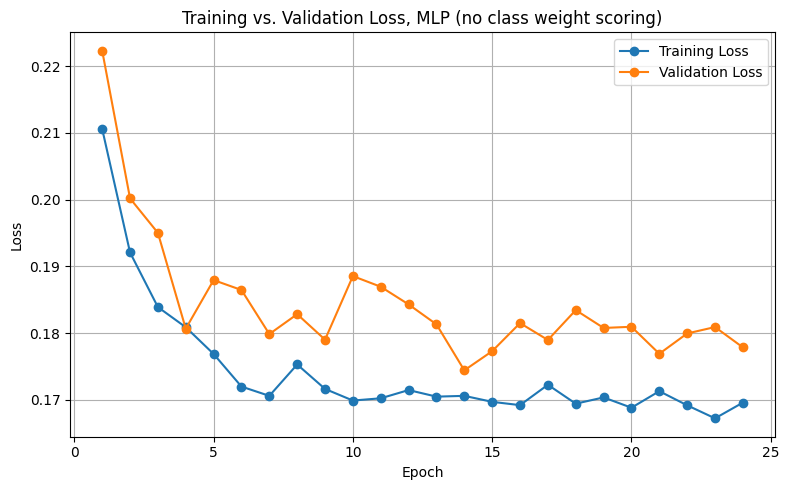

C:\Users\mayerd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mayerd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP (with class weight scoring): Early Stopping at epoch 20


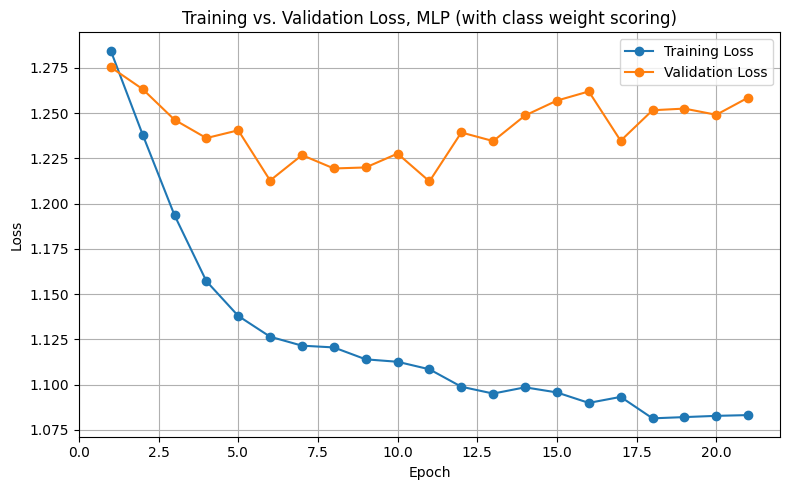

### Model Hyperparameters

,MLP (no class weight scoring),MLP (with class weight scoring)
architecture,large,small
batch_size,64,64
learning_rate,0.0005,0.0005
weight_decay,0.01,0.05
dropout,0.3,0.1
pos_weight,1.0,21.820459
epochs,120,60
early_stopping,True,True


### Model Performance on training set

,Model,Accuracy,Recall,Precision,F1,Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,MLP (no class weight scoring),0.96,0.00,0.00,0.00,0.16,0.78,479,532
1,MLP (with class weight scoring),0.73,0.69,0.11,0.18,0.56,0.79,479,4437


### Model Performance on test set

,Model,Accuracy,Recall,Precision,F1,Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,MLP (no class weight scoring),0.97,0.00,0.00,0.0,0.12,0.72,97,171
1,MLP (with class weight scoring),0.72,0.57,0.05,0.1,0.57,0.73,97,1435


In [269]:




# Train MLPs with pest performing hyperparameters on the overall training and validation set
best_params_models = {'MLP (no class weight scoring)': best_nn_params_no_class_weights,
               'MLP (with class weight scoring)': best_nn_params_with_class_weights}

# function to train and evaluate MLP with given parameters 
def train_and_evaluate_model(X_train_nn, y_train, X_val_nn, y_val, X_test_nn, y_test ,model_name, params, input_size, plotting=True):
    '''trans an MLP with given parameters on the overall training and validation set,
    evaluates model on the test set '''

    # Convert Data to pytorch tensors and rescale feature values based on the training set
    scaler = StandardScaler()
    X_train_tensor = torch.tensor(scaler.fit_transform(X_train_nn), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(scaler.transform(X_val_nn), dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(scaler.transform(X_test_nn), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)   
    
    # Define architecture of MLP (hidden layers and neurons per layer)
    if params['architecture'] == 'small':
        model = MLP_small(input_size=input_size, dropout_rate=params['dropout'])
    elif params['architecture'] == 'medium':
        model = MLP_medium(input_size=input_size, dropout_rate=params['dropout'])
    else:
        model = MLP_large(input_size=input_size, dropout_rate=params['dropout'])

    # define loss 
    def custom_bce_loss(y_pred_prob, y_true):
            w1 = params['pos_weight']
            w0 = 1 #/ (1 + w1)
            w1 = w1 #/ (1 + w1)
            crit = nn.BCELoss(reduction='none')
            ls = crit(y_pred_prob, y_true)
            return (ls * (y_true * w1 + (1 - y_true) * w0)).mean()
    criterion = custom_bce_loss

    # Adam optimizer, with learning rate and weight decay definition
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])


    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=params['batch_size'], shuffle=True)

    # Training
    validation_loss = []
    training_loss = []
    for epoch in range(params['epochs']):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Track training and validation loss
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)
            train_pred = model(X_train_tensor)
            train_loss = criterion(train_pred, y_train_tensor)
            training_loss.append(train_loss.item())
            validation_loss.append(val_loss.item())
            # print("Training loss",round(train_loss.item(),4))
            # print("Validation Loss", round(val_loss.item(),4))
            # y_train_pred_prob = model(X_train_tensor).squeeze()
            # print("Train", round(bce_scorer_probas(y_train_pred_prob,y_train_tensor),3), " vs. ", round(log_loss(y_train, y_train_pred_prob.numpy()),3))
            # y_test_pred_prob = model(X_test_tensor).squeeze()
            # print("Test",round(bce_scorer_probas(y_test_pred_prob,y_test_tensor),3), " vs. ", round(log_loss(y_test_tensor, y_test_pred_prob.numpy()),3))

            # Early stopping
            early_stopping_rounds=10
            if params['early_stopping']:
                if len(validation_loss) > early_stopping_rounds and validation_loss[-early_stopping_rounds-1] <= min(validation_loss[-early_stopping_rounds:]):
                    print(f"{model_name}: Early Stopping at epoch {epoch}")
                    break
    
    if plotting:
        # Plot training and validation loss
        epochs = range(1, len(training_loss) + 1)
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, training_loss, label='Training Loss', marker='o')
        plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training vs. Validation Loss, {model_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    # Evaluation
    model.eval()    # put model in evaluation mode (no dropout used)
    with torch.no_grad():
        # Test set predictions
        y_test_pred_prob = model(X_test_tensor).squeeze()
        y_test_pred = (y_test_pred_prob > 0.5).float()

        # Train set predictions
        y_train_pred_prob = model(X_train_tensor).squeeze()
        y_train_pred = (y_train_pred_prob > 0.5).float()

    # Test set metrics
    test_metrics = {
        'Model': model_name,
        'Accuracy': round(accuracy_score(y_test, y_test_pred), 2),
        'Recall': round(recall_score(y_test, y_test_pred), 2),
        'Precision': round(precision_score(y_test, y_test_pred), 2),
        'F1': round(f1_score(y_test, y_test_pred), 2),
        'Log Loss': round(log_loss(y_test, y_test_pred_prob.numpy()), 2),
        'ROC AUC': round(roc_auc_score(y_test, y_test_pred_prob.numpy()), 2),
        'Goals (True)': int(sum(y_test)),
        'Goals (Pred)': int(round(sum(y_test_pred_prob.numpy())))
    }

    # Train set metrics
    train_metrics = {
        'Model': model_name,
        'Accuracy': round(accuracy_score(y_train, y_train_pred), 2),
        'Recall': round(recall_score(y_train, y_train_pred), 2),
        'Precision': round(precision_score(y_train, y_train_pred), 2),
        'F1': round(f1_score(y_train, y_train_pred), 2),
        'Log Loss': round(log_loss(y_train, y_train_pred_prob.numpy()), 2),
        'ROC AUC': round(roc_auc_score(y_train, y_train_pred_prob.numpy()), 2),
        'Goals (True)': int(sum(y_train)),
        'Goals (Pred)': int(round(sum(y_train_pred_prob.numpy())))
    }

    return train_metrics, test_metrics, model

# train best model (with and without class-weights for scoring)
# Define overall training, validation and test set
X_train_nn = X_train.drop(columns=['MatchId'], errors='ignore')
X_test_nn = X_test.drop(columns=['MatchId'],errors='ignore')
X_val_nn = X_val.drop(columns=['MatchId'],errors='ignore')
train_results = []
test_results = []
best_clfs = []
input_size = len(X_train_nn.columns)
for model_name, params in best_params_models.items():
    train_result, test_result, clf = train_and_evaluate_model(
        X_train_nn=X_train_nn,
        y_train=y_train,
        X_val_nn=X_val_nn,
        y_val=y_val,
        X_test_nn=X_test_nn,
        y_test=y_test,
        model_name = model_name, 
        params = params, 
        input_size = input_size)
    train_results.append(train_result)
    test_results.append(test_result)
    best_clfs.append(clf)

mlp_clf, mlp_clf_cw = best_clfs[0], best_clfs[1] 

# set variables for the best models

# Display the hyperparameters of the best models
display(Markdown("### Model Hyperparameters"))
display(pd.DataFrame(best_params_models))

# Display results of best models on training and test set
df_results_train = pd.DataFrame(train_results)
display(Markdown("### Model Performance on training set"))
display(df_results_train)

df_results_test = pd.DataFrame(test_results)
display(Markdown("### Model Performance on test set"))
display(df_results_test)


## 3. Global Feature Importances ##

Now we have a best model using all 32 correlation-filtered features. To reduce model complexity and to ease explainability of the final models, we select 15 overall top performing features.
As the models using class weights perform better on the ROC AUC score, we continue with the best models using class-weights.
To select 15 features, 
1. Calculate global feature importance (sum of impurity reduction for tree based models / absolute SHAP values on the test set for MLP, scaled so that all feature importances sum up to 1) for each architecture.
2. Calculate average importance over all three architectures per feature, sort them by the average.
3. From the 20 features with the highest average, manually select 15 features in consultation with match analysts at TSG Hoffenheim.

First, calculate global Feature importances

In [ ]:
###############################
###############################
## Global Feature Importance ##
###############################
###############################

# Tree based models Random Forest and XGBoost: use built in scaled impurity reduction per feature
feature_names = X_test.columns
ft_importance_rf = rf_clf_cw.feature_importances_
ft_importance_xgb = xgb_clf_cw.feature_importances_


# MLP: Use summed absolute SHAP values on the test set samples
# Need to transform between numpy and torch data formats
def model_wrapper(x):
    x_tensor = torch.tensor(x, dtype=torch.float32)  # Convert NumPy array to tensor
    with torch.no_grad():
        return mlp_clf_cw(x_tensor).numpy()  # Convert output back to NumPy
# Convert input tensors to NumPy (SHAP requires NumPy arrays)
X_test_np = X_test_tensor.numpy()
# Adjust column names
explainer = shap.Explainer(model_wrapper, X_test_np, feature_names=feature_names)
# Compute SHAP values
shap_values = explainer(X_test_np)
# SHAP values are in shap_values.values with shape (n_samples, n_features)
shap_array = np.abs(shap_values.values)  # Take absolute values
# Sum over samples (axis=0) to get total importance per feature
shap_importance = shap_array.sum(axis=0)
# Normalize by the total sum to get values adding up to 1
ft_importance_mlp = shap_importance / shap_importance.sum()
# Put importances per model in a dataframe and display them
dict_model_names = {
    "Random Forest": ft_importance_rf,
    "XGBoost": ft_importance_xgb,
    "MLP": ft_importance_mlp
}
dict_ft_imps_all = {}
for name in dict_model_names.keys():
    imps = dict_model_names[name]
    dict_ft_imps = {feature_names[i]: imps[i] for i in range(len(feature_names))}
    dict_ft_imps_all[name] = dict_ft_imps


PermutationExplainer explainer: 3523it [00:42, 63.21it/s]                          


Calculate average importance over all three model architectures and display them

In [252]:
# Put importances in a dataframe
df_ft_importances = pd.DataFrame(dict_ft_imps_all)
# Compute average 
df_ft_importances["Average"] = df_ft_importances[list(dict_model_names.keys())].mean(axis=1)
# For displaying: Multiply all importances by 100 and round to 1 decimal place
df_ft_importances = df_ft_importances.map(lambda x: round(x * 100, 1))
# Sort by average importance (descending)
df_ft_importances = df_ft_importances.sort_values(by="Average", ascending=False)
# Insert position as the first column
df_ft_importances.insert(0, "Position", [f"{i+1}." for i in range(len(df_ft_importances))])
# Rename the index
df_ft_importances.index.name = "Feature Name"
display(Markdown('### Global Feature Importances (in %) over different model architectures'))
display(df_ft_importances)

### Global Feature Importances (in %) over different model architectures

,Position,Random Forest,XGBoost,MLP,Average
Feature Name,,,,,
sp_position_distance_to_goal,1.,20.8,11.4,18.9,17.1
sp_position_vertical_zone,2.,6.2,6.1,9.0,7.1
sp_first_ball_action_ball_z_max,3.,7.1,4.6,8.3,6.7
sp_heights_shot_zone_defense_mean,4.,7.4,5.5,6.5,6.4
sp_heights_shot_zone_offense_count,5.,3.6,5.5,8.9,6.0
sp_delivery_velocity,6.,4.8,3.0,4.3,4.0
sp_space_control_in_box_offense,7.,3.5,3.9,4.0,3.8
sp_delivery_distance,8.,6.0,4.1,0.7,3.6
sp_position_angle_to_goal,9.,3.7,3.2,2.9,3.3


On the basis of this analysis, the following 15 features have been selected in consultation with match analysts at TSG Hoffenheim.

In [255]:
top_15_features = ['sp_position_distance_to_goal',
                    'sp_position_vertical_zone',
                    'sp_first_ball_action_ball_z_max',
                    'sp_heights_shot_zone_defense_mean',
                    'sp_heights_shot_zone_offense_count',
                    'sp_delivery_velocity',
                    'sp_space_control_in_box_offense',
                    'sp_delivery_distance',
                    'sp_position_angle_to_goal',
                    'sp_delivery_end_position_angle_to_goal',
                    'sp_delivery_end_position_distance_to_goal',
                    'sp_defensive_pressure_shot_zone_mean',
                    'sp_avg_speeds_shot_zone_offense_mean',
                    'sp_duration',
                    'sp_heights_shot_zone_offense_mean']




# # Plot feature importance
# shap.summary_plot(shap_values, X_test_np)
# plt.show()
# sum

## 4. Model Training with reduced Features ##

with the selected top 15 features, another hyperparameter search is performed for Random Forest, XGBoost and MLP.
Based on the results of models on all features, we from now on only consider models using class weight during scoring.

In [263]:
# Define reduced Training sets only containing top 15 features
X_train_top15 = X_train[["MatchId"] + top_15_features]
X_val_top15 = X_val[["MatchId"] + top_15_features]
X_train_cv_top15 = X_train_cv[["MatchId"] + top_15_features]
X_test_top15 = X_test[top_15_features]

#
best_rf_params_top15 = randomized_search_cv_random_forrest(
    X_train=X_train_cv_top15,
    y_train=y_train_cv,
    scorer=weighed_bce_scorer,
    n_folds=5,
    n_iter=100,
    random_state=random_state
)

best_xgb_params_top15 = randomized_search_cv_xgboost(
    X_train=X_train_cv_top15,
    y_train=y_train_cv,
    scorer=weighed_bce_scorer,
    n_folds=5,
    n_iter=100,
    random_state=random_state
)

best_nn_params_top15 = randomized_search_cv_nn(
    X_train=X_train_cv_top15,
    y_train=y_train_cv,
    scorer=bce_scorer_probas,
    n_folds=5,
    n_iter=40,
    random_state=random_state
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Average score of best parameters over 5 folds:  -1.18050079594461
Standard deviation of score of best parameters over 5 folds:  0.09047050035620532
Training XGBoost with randomized search and cross-validation
Number of parameter combinations:  100
Number of folds:  5
Total number of models:  500


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2570392352.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -1.1921
Standard Deviation of best combination over splits:  0.0533
Training MLP with randomized search and cross-validation
Number of parameter combinations:  40
Number of folds:  5
Total number of models:  200


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\3155848205.py:257: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -0.1656
Standard Deviation of best combination over splits:  0.00719


Train and evaluate the best model for each architecture

In [280]:
X_train_top15 = X_train_top15[top_15_features]
X_val_top15 = X_val_top15[top_15_features]
X_train_cv_top15 = X_train_cv_top15[top_15_features]
X_test_top15 = X_test_top15[top_15_features]

## Train Best Random forest with top 15 features
rf_clf_top15 = RandomForestClassifier(**best_rf_params_top15, random_state=random_state)
rf_clf_top15.fit(X_train_cv_top15, y_train_cv)

## Train best XGBoost with top 15 Features
xgb_clf_top15 = xgb.XGBClassifier(**best_xgb_params_top15)
xgb_clf_top15.fit(
                X_train_top15, y_train,
                eval_set=[(X_val_top15, y_val)],
                verbose=False
            )

## Train best MLP with top 15 Features
train_result, test_result, mlp_clf_top15 = train_and_evaluate_model(
        X_train_nn=X_train_nn,
        y_train=y_train,
        X_val_nn=X_val_nn,
        y_val=y_val,
        X_test_nn=X_test_nn,
        y_test=y_test,
        model_name = "MLP", 
        params = params, 
        input_size = input_size,
        plotting=False)

## Evaluate all three models
display(Markdown('## Model Performance using Class weights and the Top 15 Features'))

evaluate_models_on_trainingset({"RandomForest": rf_clf_top15, "XGBoost":xgb_clf_top15}, top_15_features, add_info={"MLP": train_result})

evaluate_models_on_testset({"RandomForest": rf_clf_top15, "XGBoost":xgb_clf_top15}, top_15_features, add_info={"MLP": test_result})


MLP: Early Stopping at epoch 17


## Model Performance using Class weights and the Top  15 Features

### Evaluation Results on Training Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,RandomForest,0.84,0.61,0.15,0.24,0.50,0.85,479,4149
1,XGBoost,0.73,0.77,0.12,0.20,0.57,0.83,479,4701
2,MLP,0.73,0.68,0.10,0.18,0.56,0.79,479,4482


### Evaluation Results on Test Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,RandomForest,0.84,0.44,0.08,0.13,0.51,0.75,97,1321
1,XGBoost,0.71,0.57,0.05,0.10,0.58,0.74,97,1506
2,MLP,0.71,0.56,0.05,0.10,0.57,0.73,97,1448


## 5. Model Interpretation ##



Using the best models on the top 15 features, the shapley values are inspected on a single sample level

In [ ]:
### Printe Klassischen SHAP Plot, Shap Plot per feature und einen Force plot als beispiel mit den top 15 modellen